<h1>
      <h4>
          <p style="font-size:36pt">MSIN0143 Programming for Business Analytics (Group G2 project)</p>
          <p style="font-size:36pt">Predicting Car Loan default rates using customer characteristics </p>
          <br /><br />

# Table of Contents
* [1. Introduction](#1.-Introduction)
    * [1.1. Objectives](#1.1.-Objectives)
    * [1.2. Defining bespoke Functions](#1.2.-Defining-bespoke-Functions)
* [2. Data](#2.-Data)
    * [2.1. Data Description](#2.1.-Data-Description)
    * [2.2. Data Upload and Preparation](#2.2.-Data-Upload-and-Preparation)
    * [2.3. Data Cleaning](#2.3.-Data-Cleaning)
* [3. Exploratory Data Analysis (EDA)](#3.-Exploratory-Data-Analysis-(EDA))
    * [3.1. First Order Insights](#3.1.-First-Order-Insights)
    * [3.2. Data Manipulation and Winsorisation](#3.2.-Data-Manipulation-and-Winsorisation)
    * [3.3. Identifying further outliers](#3.3.-Identifying-further-outliers)
    * [3.4. Analysis by Attribute](#3.4.-Analysis-by-Attribute)
    * [3.5. EDA Summary](#3.5.-EDA-Summary)
* [4. Modelling](#4.-Modelling)
    * [4.1. Weight of Evidence](#4.1.-Weight-of-Evidence)
    * [4.2. Train and test sample split](#4.2.-Train-and-test-sample-split)
    * [4.3. Logistic Regression](#4.3.-Logistic-Regression)
    ** [4.3.1. Candidate model 1](#4.3.1.-Candidate-model-1)
    ** [4.3.2. Stepwise approach](#4.3.2.-Stepwise-approach)
    ** [4.3.3. Candidate model 2](#4.3.3.-Candidate-model-2)
    ** [4.3.4. Variable selection using WoE and IV](#4.3.4.-Variable-selection-using-WoE-and-IV)
    ** [4.3.5. Candidate model 3](#4.3.5.-Candidate-model-3)
    * [4.4. XGBoost](#4.4.-XGBoost)
    ** [4.4.1. Candidate model 4](#4.4.1.-Candidate-model-4)
* [5. Conclusions and Limitations](#5.-Conclusions-and-Limitations)
* [7. References](#7.-References)


In [198]:
import json
def wordcount(nb_filename):
    with open(nb_filename) as json_file:
        data = json.load(json_file)
    wordCount = 0
    for each in data['cells']:
        cellType = each['cell_type']
        if cellType == "markdown":
            content = each['source']
            for line in content:
                temp = [word for word in line.split()]
                wordCount = wordCount + len(temp)
    return wordCount
wordcount("MSIN0143_2022_GROUP_G2_excl_appendix.ipynb")

2012

# 1. Introduction
Financial Institutions (FI) are cash providers that aim to facilitate investment within the economy. Banks and finance companies provide funding and make a profit through interest. To optimise profits FIs need to minimise loan defaults by giving out loans to appropriate obligors. Loan default can harm financial institutions and therefore, it is critical to predict who might default on their debt and should therefore be denied a loan. 

# 1.1. Objectives
In this case study, we analyse a car loan dataset from an Indian FI company, L&T Financial Services. We aim to discover what features drive loan default rates and use those insights to build a model to predict customers with high probabilities of default (PD). 

We introduce the dataset and prepare it for manipulation. This will be followed by exploratory data analysis (EDA) to uncover relationships between explanatory variables and loan defaults. Based on our findings we then build our model. The modelling section is followed by conclusions and limitations to highlight potential data quality (DQ) issues and to describe the pitfalls we encountered during our work. 

In [77]:
# Autosaving and making sure every output is printed
%autosave 120
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Autosaving every 120 seconds


In [78]:
%%capture
# this magic command suppresses the installation output
# Installing relevant Python packages and modules 
from IPython import display as dp

# Installing researchpy and pandas_profiling package. Uncomment if necessary.
!pip install researchpy
!pip install pandas_profiling 
!pip install xgboost 

# Importing relevant Python libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import datetime
import researchpy as rp
import statsmodels.api as sm

# Datetime is required to handle dates within our data
from datetime import timedelta

import warnings

%matplotlib inline

# Installing relevant modules that will be used throughout the project
from pandas_profiling import ProfileReport
from pandas import Series, DataFrame

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report,confusion_matrix, auc
import sklearn.metrics as metrics
from xgboost import XGBClassifier

In [79]:
# Setting the parameters to print all rows and columns if we wish in pandas
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

## 1.2. Defining bespoke functions

In [80]:
# This is to create a new column for whether some form of identification has been provided for the loan
def id_conditions(dataframe):
    if (dataframe['Aadhar_flag'] == 1) or\
    (dataframe['PAN_flag'] == 1) or \
    (dataframe['VoterID_flag'] == 1) or \
    (dataframe['Driving_flag'] == 1) or (dataframe['Passport_flag'] == 1):
        return 1
    else:
        return 0

In [81]:
# This function plots two overlapping histograms by default status
def default_histogram(dataframe,independent_variable, bin_no = 20):
    plt.figure(figsize=(8,6))
    plt.hist(df[independent_variable].loc[df.loc[:,'loan_default'] == 1], \
             bins= bin_no, alpha=0.5, color='r', label="Defaulted cases")
    plt.hist(df[independent_variable].loc[df.loc[:,'loan_default'] == 0], \
             bins= bin_no, alpha=0.5, color='g', label="Non-defaulted cases")
    plt.xlabel(independent_variable, size=14)
    plt.ylabel("Count", size=14)
    plt.title(independent_variable + " histograms by default status")
    plt.legend(loc='upper right')
    plt.savefig("EDA_output/ {}_histograms_default_status.png".format(independent_variable))
    plt.show()

In [82]:
# Calculate information value
def calc_woe_iv(df, feature, target, print_full_results=1, continuous= True, bins= 12):
    lst = []
    # If the feature is categorical, there is no need to group it in bins
    if continuous==False:
        for i in range(df[feature].nunique()):
            val = list(df[feature].unique())[i]
            lst.append([feature, val, df[df[feature] == val].count()[feature], \
                        df[(df[feature] == val) & (df[target] == 1)].count()[feature]])
    else:
        df['binned_feature'] = pd.qcut(df[feature], bins,  duplicates='drop')
        for i in range(df['binned_feature'].nunique()):
            val = list(df['binned_feature'].unique())[i]
            lst.append([feature, val, df[df['binned_feature'] == val].count()['binned_feature'], \
                        df[(df['binned_feature'] == val) & (df[target] == 1)].count()['binned_feature']])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if print_full_results == 1:
        display(data)
    
    return data[['Variable', 'IV']].values[0]

In [83]:
# Perform winsorisation (flooring and capping) on numerical variables
def winsorise(df, variable, percentile_lower = 0.025, percentile_upper = 0.975, cap_only = True):
    if cap_only == True:
        df[variable].loc[df.loc[:,variable]>df[variable].quantile(q=percentile_upper)] = df[variable].quantile(q=percentile_upper)
    else:
        df[variable].loc[df.loc[:,variable]>df[variable].quantile(q=percentile_upper)] = df[variable].quantile(q=percentile_upper)
        df[variable].loc[df.loc[:,variable]<df[variable].quantile(q=percentile_lower)] = df[variable].quantile(q=percentile_lower)

In [84]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.Logit
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            idx = new_pval.argmin()
            new_pval_ = new_pval.reset_index()
            best_feature = new_pval_.iloc[idx,0]
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            idx = pvalues.argmax()
            pvalues_ = pvalues.reset_index()
            worst_feature = pvalues_.iloc[idx,0]
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

# 2. Data

## 2.1. Data Description
This car loan default dataset is sourced from Kaggle <a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), with 233,154 observations, 40 variables and 1 target variable (loan default status). There are two csv files **"train.csv"** and **"test.csv"**. However, the **"test.csv"** dataset is missing the target variable. We, therefore, only proceed with the train one. 

## 2.2. Data Upload and Preparation

In [85]:
# Importing the two data sets
df_test = pd.read_csv('Data/test.csv')
df_orig= pd.read_csv('Data/train.csv')

In [86]:
# Checking whether data has been uploaded accurately
df_test.head()
df_orig.head()

# Number of rows and column in each dataset
df_test.shape
df_orig.shape

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,03-11-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,20-11-18,6,1998,1,1,0,0,0,0,749,C-Very Low Risk,2,1,0,43898,48780,48780,0,0,0,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,29-11-18,4,1646,1,1,1,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,29-11-18,4,1646,1,1,0,0,0,0,14,Not Scored: Only a Guarantor,1,1,1,132480,255000,255000,0,0,0,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,17-11-18,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


(112392, 40)

(233154, 41)

In [87]:
# Checking for missing values 
df_orig.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        7661
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

## 2.3. Data Cleaning

In [88]:
# We might encounter errors when we run code with variables name including a dot as they will indicate to Python that the object name ends. 
# We therefore replace '.' with '_'. 
df_orig.columns = df_orig.columns.str.replace('.','_') 

# Additionally, we rename all columns to lower case in order to ensure consistency.
df_orig.columns = df_orig.columns.str.lower()

df_orig.head()

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


### Wrong date types
The dataset contains several object types because python misidentified certain column entries such as dates or the entries that are in character form.

In [89]:
# Checking data types
df_orig.dtypes

uniqueid                                 int64
disbursed_amount                         int64
asset_cost                               int64
ltv                                    float64
branch_id                                int64
supplier_id                              int64
manufacturer_id                          int64
current_pincode_id                       int64
date_of_birth                           object
employment_type                         object
disbursaldate                           object
state_id                                 int64
employee_code_id                         int64
mobileno_avl_flag                        int64
aadhar_flag                              int64
pan_flag                                 int64
voterid_flag                             int64
driving_flag                             int64
passport_flag                            int64
perform_cns_score                        int64
perform_cns_score_description           object
pri_no_of_acc

We create a new column to calculate the age of each obligor because continuous variables are more useful for data exploration.

In [90]:
# Convert date variables to pandas datetime format and create a new variable called obligor_age which is the age of the person that took out the loan
df_orig["date_of_birth"] = pd.to_datetime(df_orig["date_of_birth"], format="%d-%m-%y", errors='raise')
df_orig["disbursaldate"] = pd.to_datetime(df_orig["disbursaldate"], format="%d-%m-%y", errors='raise')
df_orig["obligor_age"] = ((df_orig["disbursaldate"]-df_orig["date_of_birth"]) / pd.Timedelta("365 days")).apply(np.floor).astype("int")

print(df_orig["obligor_age"].head())

0    34
1    33
2    32
3    24
4    40
Name: obligor_age, dtype: int64


There are 19,866 entries where the obligor's date of birth indicates they are younger than 18. It turns out that a large part of the data was imported incorrectly and a date such as "68-01-01" was imported as "2068-01-01". This issue was fixed by simply deducting 100 years where birth year was larger than 2020. 

In [91]:
len(df_orig.loc[df_orig["obligor_age"]<18])
df_orig.loc[df_orig["obligor_age"]<18].head()

19866

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age
9,510980,52603,61300,86.95,67,22807,45,1492,2068-06-01,Salaried,2018-09-16,6,1998,1,0,0,1,0,0,818,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0,-50
26,440293,53713,61780,89.83,67,22807,45,1468,2068-08-02,Self employed,2018-08-16,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1,-50
32,501823,57259,70100,82.74,67,22807,45,1497,2066-06-01,Salaried,2018-09-12,6,1998,1,0,0,1,0,0,768,B-Very Low Risk,7,3,0,324323,604845,604845,0,0,0,0,0,0,1219,0,1,0,1yrs 10mon,4yrs 10mon,0,0,-48
59,460555,48500,59313,83.79,78,17014,45,2070,2064-06-01,Salaried,2018-08-24,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,-46
68,517611,46759,62577,78.30,78,17014,45,2102,2067-01-01,Salaried,2018-09-19,4,1646,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,-49


In [92]:
# Substracting 100 years from the birth years larger or equal 2020
df_orig.loc[df_orig["date_of_birth"].dt.year >= 2020, "date_of_birth"] -= pd.DateOffset(years=100)

# The earliest disbursal date in the data set was August 1st 2018. It appears there are still some obligors who are younger than 18. 
# However, the correct age needs to be calculated again due to different disbursal dates

len(df_orig.loc[df_orig["date_of_birth"]>"2000-08-01"])
df_orig.loc[df_orig["date_of_birth"]>"2000-08-01"].head()

70

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age
1872,510327,73217,106503,70.33,63,17066,86,7094,2000-08-18,NaN,2018-09-16,10,413,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,18
8357,630035,61558,74837,85.00,85,17139,86,1936,2000-10-20,NaN,2018-10-27,4,369,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1,18
9786,642745,58159,70326,85.17,17,20335,86,3271,2000-08-05,NaN,2018-10-30,17,351,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1,18
11759,457178,44149,53850,84.12,153,16053,45,369,2000-08-05,NaN,2018-08-22,11,1331,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,18
14290,652206,77751,108500,73.73,152,18578,48,6065,2000-10-02,NaN,2018-10-31,3,968,1,1,0,0,0,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,80000,80000,80000,0,0,0,0,0,0,0,0,1,0,0yrs 0mon,0yrs 0mon,0,0,18


In [93]:
# We recalculate obligor age after having corrected the date of birth column
df_orig["obligor_age"] = ((df_orig["disbursaldate"]-df_orig["date_of_birth"]) / pd.Timedelta("365 days")).apply(np.floor).astype("int")
len(df_orig.loc[df_orig["obligor_age"]<18])

0

In [94]:
df_orig["date_of_birth"].head()

0   1984-01-01
1   1985-07-31
2   1985-08-24
3   1993-12-30
4   1977-12-09
Name: date_of_birth, dtype: datetime64[ns]

### Account Age and Credit History Length
**Average account age** and **credit history length** are in an unpractical X years Y months format which we transformed to continuous variables in months.

In [95]:
# Turning AVERAGE_ACCT_AGE into two columns and finding account age in months
df_orig["average_acct_age"] = df_orig["average_acct_age"].str.replace("yrs","")
df_orig["average_acct_age"] = df_orig["average_acct_age"].str.replace("mon","")
df_orig[["acct_year","acct_mon"]] = df_orig["average_acct_age"].str.split(" ", expand= True).astype("int")
df_orig["avg_account_age"] = 12*df_orig["acct_year"] + df_orig["acct_mon"]

# Turning CREDIT_HISTORY_LENGTH into two columns and finding account age in months
df_orig["credit_history_length"] = df_orig["credit_history_length"].str.replace("yrs","")
df_orig["credit_history_length"] = df_orig["credit_history_length"].str.replace("mon","")
df_orig[["hist_year","hist_mon"]] = df_orig["credit_history_length"].str.split(" ", expand= True).astype("int")
df_orig["credit_history_length"] = 12*df_orig["hist_year"] + df_orig["hist_mon"]


In [96]:
# Sanity checking max credit history length and account age 
df_orig[["credit_history_length","avg_account_age"]].max()
df_orig[["credit_history_length","avg_account_age"]].max()

credit_history_length    468
avg_account_age          369
dtype: int64

credit_history_length    468
avg_account_age          369
dtype: int64

In [97]:
# Checking whether those maximum values correspond with the rest of the information about these obligors
df_orig.loc[df_orig["avg_account_age"]==369]
df_orig.loc[df_orig["credit_history_length"]==468]

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age,acct_year,acct_mon,avg_account_age,hist_year,hist_mon
56379,635951,58013,74791,80.22,152,13890,86,4920,1996-04-30,Self employed,2018-10-29,3,401,1,0,0,1,0,0,18,Not Scored: No Updates available in last 36 mo...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30 9,369,0,0,22,30,9,369,30,9


,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age,acct_year,acct_mon,avg_account_age,hist_year,hist_mon
93886,629904,72717,106061,70.62,251,22993,51,6868,1965-10-01,Self employed,2018-10-27,13,255,1,0,0,1,0,0,599,I-Medium Risk,8,4,0,189465,223023,223023,0,0,0,0,0,0,77847,0,0,0,7 4,468,0,1,53,7,4,88,39,0


In [98]:
# In order to further check our age entries we analyse whether certain obligors have an account age 
# that would suggest they obtained a loan before they were 18.

# Creating a maximum account age which can only be possible when an obligor took opened an accounnt on the day of their 18th birthday
df_orig["max_acct_age"] = df_orig["disbursaldate"] - (df_orig["date_of_birth"] + timedelta(days=6570))
df_orig['max_acct_age'] = df_orig['max_acct_age'].dt.days

# Creating red flag for credit history length 
df_orig["hist_len_red_flag"]= np.where((df_orig["credit_history_length"]*30.437)>df_orig["max_acct_age"],1,0)
print("The number of cases which indicate a loan obtained by an underage customer is {}.".format(len(df_orig.loc[df_orig["hist_len_red_flag"]==1])))
df_orig.loc[df_orig["hist_len_red_flag"]==1].head()


The number of cases which indicate a loan obtained by an underage customer is 1008.


,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age,acct_year,acct_mon,avg_account_age,hist_year,hist_mon,max_acct_age,hist_len_red_flag
154,488655,40394,65368,62.72,34,15196,86,992,1996-05-04,Salaried,2018-09-04,6,1863,1,1,0,0,0,0,825,A-Very Low Risk,1,0,0,0,0,0,2,2,1,1171994,1690000,1690000,1090,9382,0,0,3 1,60,0,0,22,3,1,37,5,0,1588,1
1544,629365,53303,67933,80.96,63,16309,45,7093,1990-03-04,Self employed,2018-10-27,10,998,1,1,0,0,0,0,471,K-High Risk,3,0,1,0,0,0,1,1,0,0,34415,34415,3296,0,0,1,3 2,143,1,0,28,3,2,38,11,11,3894,1
1768,561815,51803,71060,74.58,63,21879,86,7102,1998-04-08,NaN,2018-10-08,10,413,1,1,0,0,0,0,447,K-High Risk,1,1,1,24995,30000,30000,1,1,0,25367,39161,39161,0,2563,0,0,3 5,74,0,1,20,3,5,41,6,2,918,1
1812,604259,75251,95951,80.25,63,21879,86,7100,1998-03-08,NaN,2018-10-23,10,413,1,1,0,0,0,0,665,F-Low Risk,2,1,0,44287,45000,45000,0,0,0,0,0,0,0,0,0,0,2 0,36,0,1,20,2,0,24,3,0,964,1
2210,611210,62382,73320,89.33,3,17038,51,571,1992-02-19,Self employed,2018-10-24,15,624,1,1,1,0,0,0,623,H-Medium Risk,4,3,0,18899,59008,59008,9,2,0,1555003,1973306,1973306,7180,0,1,0,2 0,109,0,0,26,2,0,24,9,1,3174,1


We also repeat the same process for **credit history length** and realise that there are more problematic entries.

In [99]:
# Creating a red flag variable in order to find the ones where acct_age is somehow older than their age minus 18
# We reuse max_acct_age column from the previous codechunk
df_orig["acct_age_red_flag"]= np.where((df_orig["avg_account_age"]*30.437)>df_orig["max_acct_age"],1,0)
len(df_orig.loc[df_orig["acct_age_red_flag"]==1])
df_orig.loc[df_orig["acct_age_red_flag"]==1].head()

490

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,date_of_birth,employment_type,disbursaldate,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,perform_cns_score_description,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,average_acct_age,credit_history_length,no_of_inquiries,loan_default,obligor_age,acct_year,acct_mon,avg_account_age,hist_year,hist_mon,max_acct_age,hist_len_red_flag,acct_age_red_flag
1768,561815,51803,71060,74.58,63,21879,86,7102,1998-04-08,NaN,2018-10-08,10,413,1,1,0,0,0,0,447,K-High Risk,1,1,1,24995,30000,30000,1,1,0,25367,39161,39161,0,2563,0,0,3 5,74,0,1,20,3,5,41,6,2,918,1,1
3330,563986,58259,81052,72.79,146,14142,45,2997,1999-12-13,NaN,2018-10-08,14,661,1,1,0,0,0,0,709,D-Very Low Risk,4,3,0,172984,195500,195500,0,0,0,0,0,0,3960,0,1,0,0 11,22,0,0,18,0,11,11,1,10,304,1,1
3698,610923,62213,76500,82.35,16,21980,86,2946,1999-01-22,NaN,2018-10-24,14,430,1,1,0,0,0,0,836,A-Very Low Risk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2 1,25,0,0,19,2,1,25,2,1,645,1,1
3923,459486,19674,67500,31.11,147,17223,86,2784,1993-01-01,Salaried,2018-08-23,2,45,1,1,0,0,0,0,640,G-Low Risk,1,1,1,15,15,15,0,0,0,0,0,0,0,0,0,0,7 9,93,0,0,25,7,9,93,7,9,2795,1,1
5111,631541,65882,82200,81.51,1,23004,86,5083,1999-12-20,NaN,2018-10-27,3,290,1,0,0,1,0,0,611,H-Medium Risk,13,3,0,38143,50500,50500,0,0,0,0,0,0,12208,0,1,0,1 3,66,0,0,18,1,3,15,5,6,316,1,1


In [100]:
# Taking a specific look at those entries and understanding the underlying error
df_orig[['date_of_birth', 'disbursaldate','avg_account_age', 'credit_history_length']].loc[df_orig["acct_age_red_flag"]==1].head()

,date_of_birth,disbursaldate,avg_account_age,credit_history_length
1768,1998-04-08,2018-10-08,41,74
3330,1999-12-13,2018-10-08,11,22
3698,1999-01-22,2018-10-24,25,25
3923,1993-01-01,2018-08-23,93,93
5111,1999-12-20,2018-10-27,15,66


In [101]:
df_orig[["avg_account_age","credit_history_length"]].describe()

,avg_account_age,credit_history_length
count,233154.000000,233154.000000
mean,8.915764,16.252404
std,15.106416,28.581255
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,13.000000,24.000000
max,369.000000,468.000000


We decided to drop the 1,008 entries (<0.5% of total data). 

In [102]:
# Dropping rows where hist_len_red_flag ==1
df_orig = df_orig.drop(df_orig[df_orig["hist_len_red_flag"]==1].index)

In [103]:
# Deleting problematic credit history length cases also deals with strange average account ages
len(df_orig.loc[df_orig["hist_len_red_flag"]==1])
len(df_orig.loc[df_orig["acct_age_red_flag"]==1])
len(df_orig)

0

0

232146

In [104]:
# Lastly we  drop the help columns we created 
df_orig.drop(df_orig[["hist_len_red_flag","acct_age_red_flag","max_acct_age","acct_year","acct_mon","hist_year","hist_mon","average_acct_age"]], inplace=True, axis=1)
df_orig.columns

Index(['uniqueid', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'current_pincode_id', 'date_of_birth',
       'employment_type', 'disbursaldate', 'state_id', 'employee_code_id',
       'mobileno_avl_flag', 'aadhar_flag', 'pan_flag', 'voterid_flag',
       'driving_flag', 'passport_flag', 'perform_cns_score',
       'perform_cns_score_description', 'pri_no_of_accts', 'pri_active_accts',
       'pri_overdue_accts', 'pri_current_balance', 'pri_sanctioned_amount',
       'pri_disbursed_amount', 'sec_no_of_accts', 'sec_active_accts',
       'sec_overdue_accts', 'sec_current_balance', 'sec_sanctioned_amount',
       'sec_disbursed_amount', 'primary_instal_amt', 'sec_instal_amt',
       'new_accts_in_last_six_months', 'delinquent_accts_in_last_six_months',
       'credit_history_length', 'no_of_inquiries', 'loan_default',
       'obligor_age', 'avg_account_age'],
      dtype='object')

#### Employment status 

In [105]:
# It is a character variable which is either self_employed, salaried or NaN. 
# We turn that column into a numerical variable by transforming it into a dummy variable.

# Defining three dummy variables and turning NaN entries into "no employment info"
df_orig["self_employed"] = np.where(df_orig["employment_type"]=="Self employed",1,0)
df_orig["salaried"] = np.where(df_orig["employment_type"]=="Salaried",1,0)
df_orig["no_employment_info"] = np.where(df_orig["employment_type"].isnull()==True,1,0)
df_orig['employment_type'] = np.where(df_orig["employment_type"].isnull()==True, "No employment info", df_orig["employment_type"])

df_orig[["self_employed","salaried","no_employment_info"]].head()

,self_employed,salaried,no_employment_info
0,0,1,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


# 3. Exploratory Data Analysis (EDA)

We explore our data to derive further insights through distributions of variables and deciding whether we must address certain outliers. Furthermore, we check if there are any relationships between the explanatory variables and loan defaults.

# 3.1. First Order Insights

In [106]:
# For the EDA we create a copy of the cleaned version of df_orig
df = df_orig.copy()

## ProfileReport

<span style="color:red"> WARNING: Profiler function will take about 5' to run. </span>

In [107]:
# The ProfileReport function provides statistical values such as mean, quantiles and histograms. 
# It is convenient for us to get statistical details of the variables. 
# We found that the continuous variables such as disbursed amount, asset cost and sanctioned amount fall into the interval with low values.

# Taking a 5% random sample of the full dataset without replacement due to the fact that the function crashes if it is executed on the full df
sample_df = df.sample(frac= 0.05, replace= False, random_state= 777)

# ProfileReport generates three reports for all variables, namely, statistical overview, warnings, and reproduction section.
profile = ProfileReport(sample_df, title = 'Default Dataset Report', explorative= True)
display(profile)

## Correlation Heatmap 
The heatmap visualises the strength of two-dimensional correlation between all variables, with red representing positive corelation and blue for negative correlation. 

In [108]:
%matplotlib inline
warnings.filterwarnings("ignore")
# Round the correlation values with respect to our predicted value "loan_default" in our matrix to 2 digits to make them easier to read.
corr_matrix =df.corr().round(2)
corr_matrix["loan_default"].sort_values(ascending=False)

loan_default                           1.00
ltv                                    0.10
disbursed_amount                       0.08
state_id                               0.05
pri_overdue_accts                      0.04
no_of_inquiries                        0.04
voterid_flag                           0.04
branch_id                              0.03
supplier_id                            0.03
self_employed                          0.03
current_pincode_id                     0.03
delinquent_accts_in_last_six_months    0.03
uniqueid                               0.03
employee_code_id                       0.02
asset_cost                             0.01
sec_instal_amt                        -0.00
sec_overdue_accts                     -0.00
no_employment_info                    -0.00
pan_flag                               0.00
passport_flag                         -0.01
sec_current_balance                   -0.01
driving_flag                          -0.01
primary_instal_amt              

Many variables with similar meaning have a high positive or negative correlation. This means that there would be a multicollinearity issue if they were all  to be included in the model. According to the heatmap, we found that there is low correlation between each variable and loan default.

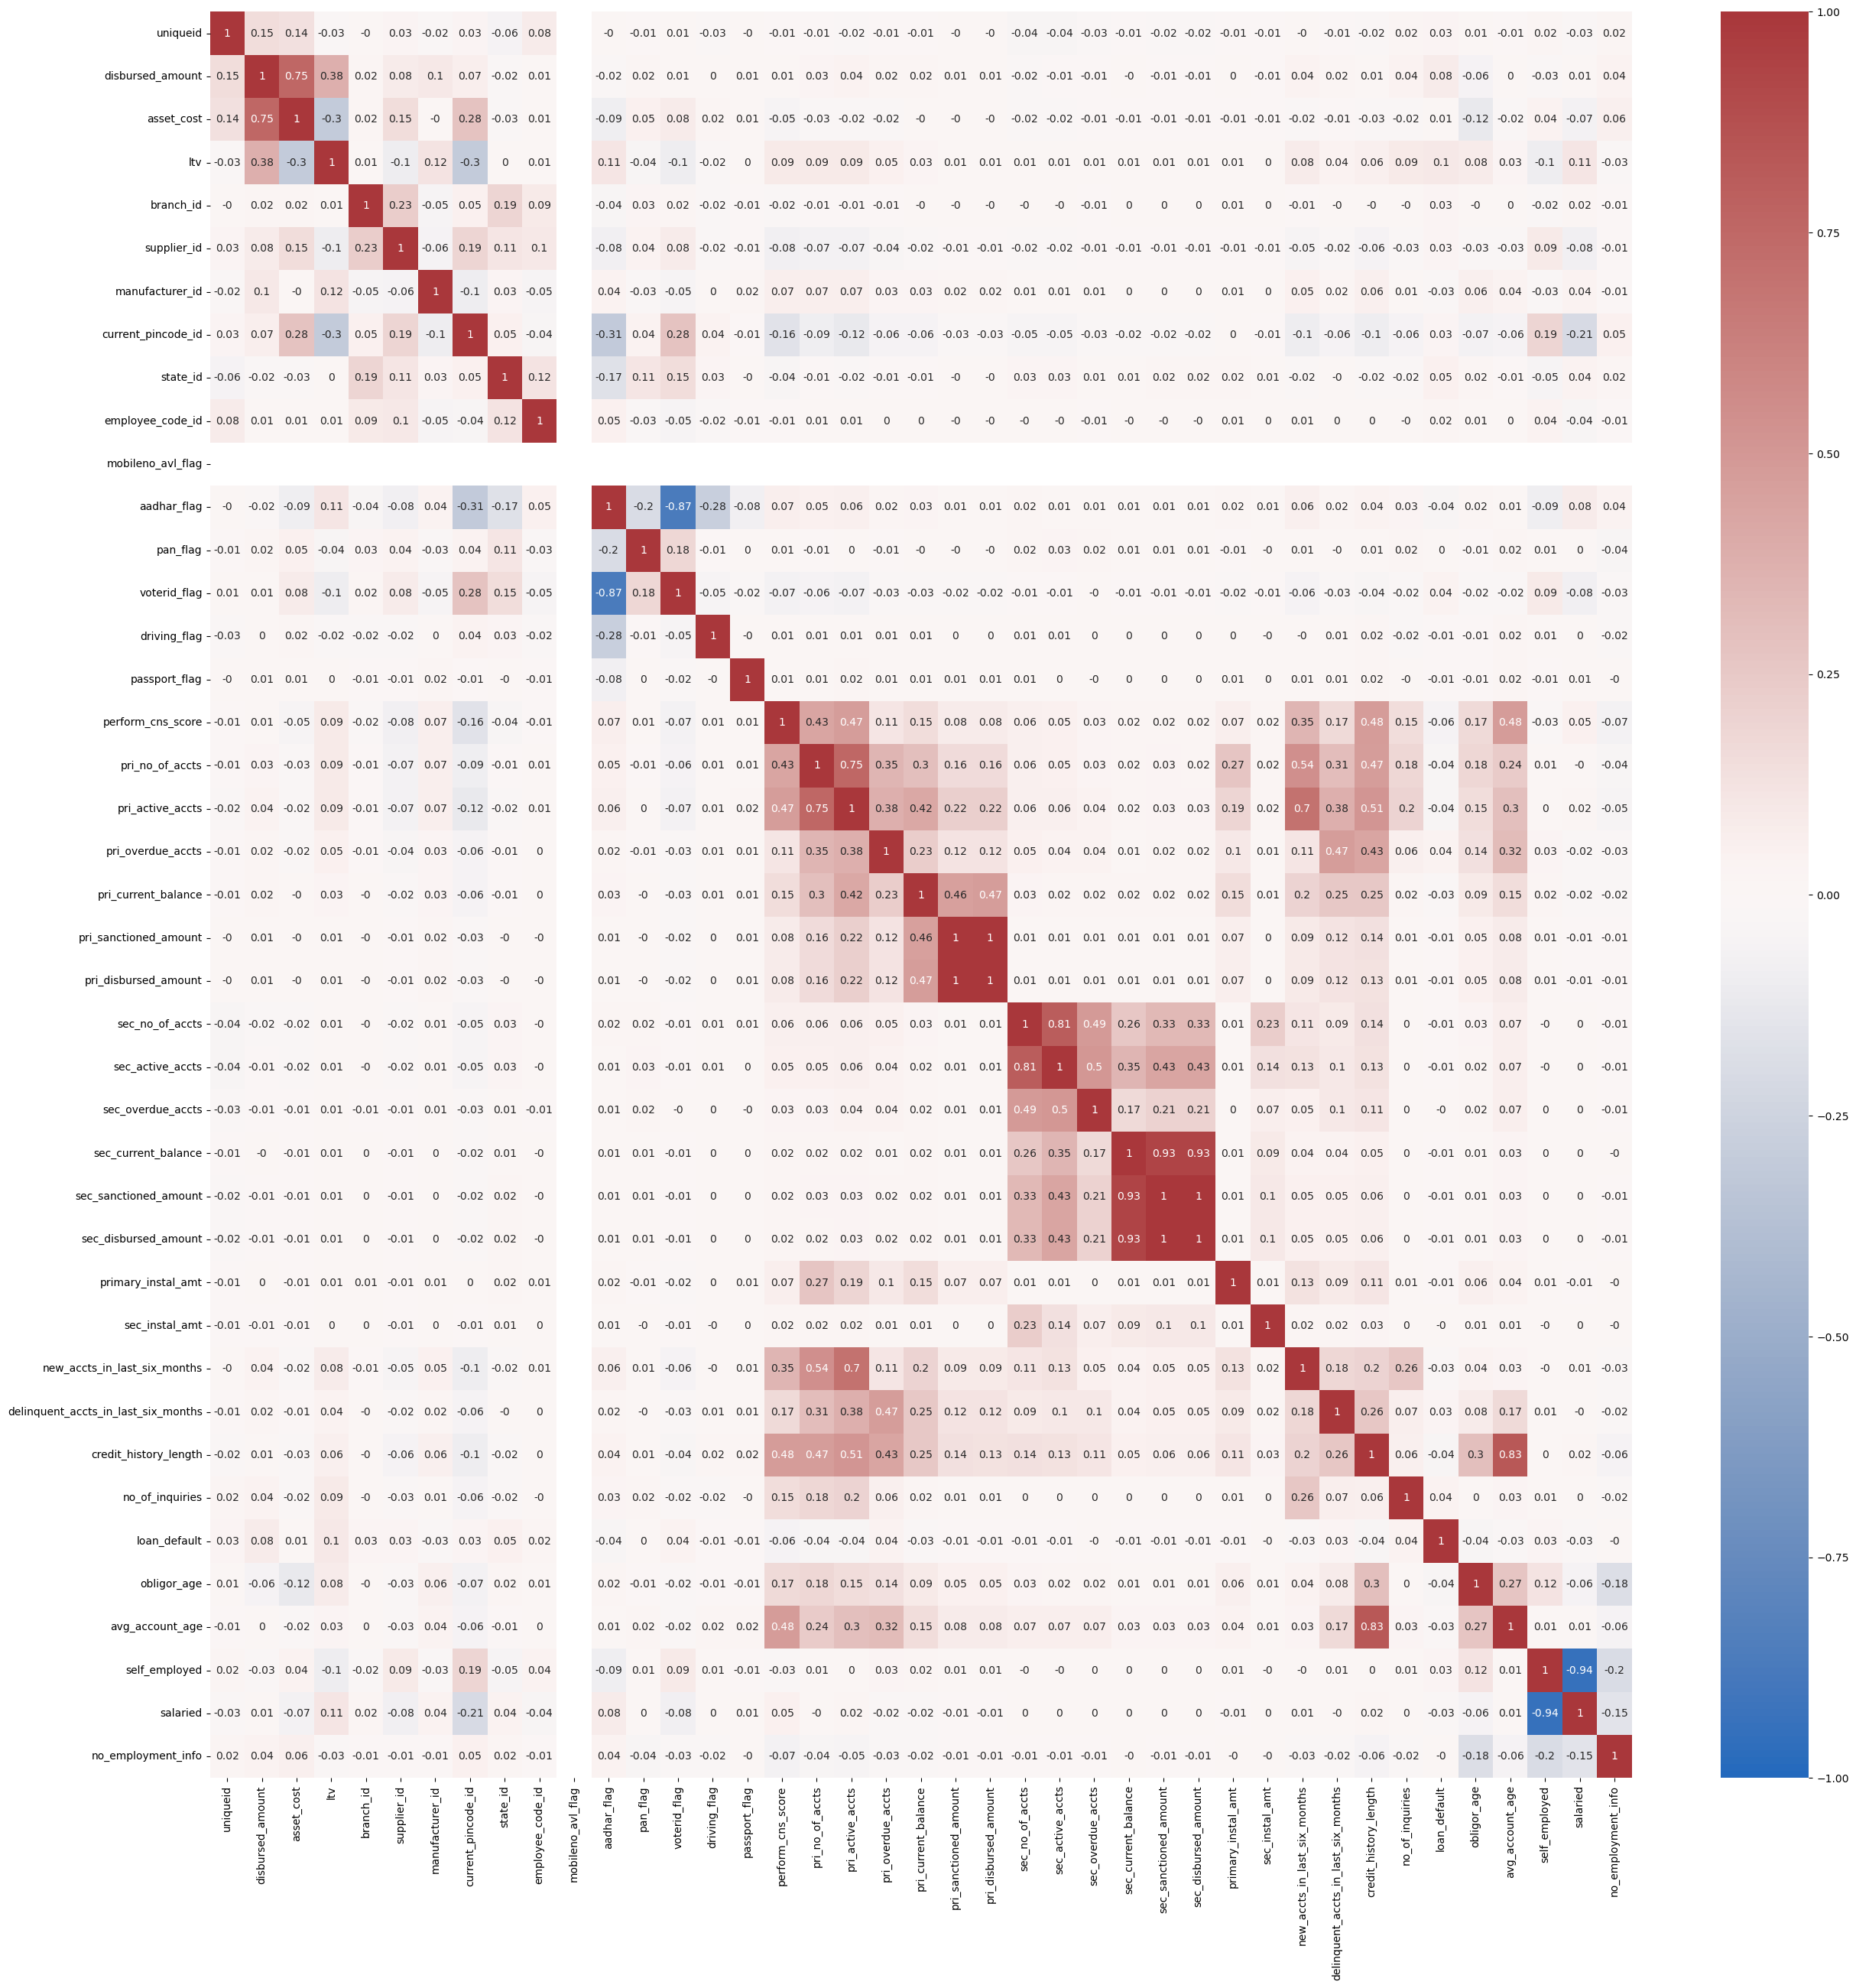

In [109]:
# Heatmaps
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix, cbar=True,annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
# plt.show()
plt.savefig('EDA_output/heatmap.png');

# 3.2. Data Manipulation and Winsorisation

In [110]:
# We check if there are negative values for the monetary fields in the dataset by calculating the minimum
df[['disbursed_amount', 'asset_cost','pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_current_balance', 'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']].min()

disbursed_amount           13320
asset_cost                 37000
pri_current_balance     -6678296
pri_sanctioned_amount          0
pri_disbursed_amount           0
sec_current_balance      -574647
sec_sanctioned_amount          0
sec_disbursed_amount           0
primary_instal_amt             0
sec_instal_amt                 0
dtype: int64

In [111]:
print(len(df.loc[df["pri_current_balance"]<=0]))
print(len(df.loc[df["sec_current_balance"]<=0]))

141928
228971


Primary and secondary current balances indicate the oustanding principal amount from the loans. We encounter negative values for over half of the dataset which makes it unlikely to be an error.

Without any further information, we prefer not to apply any flooring to these variables.

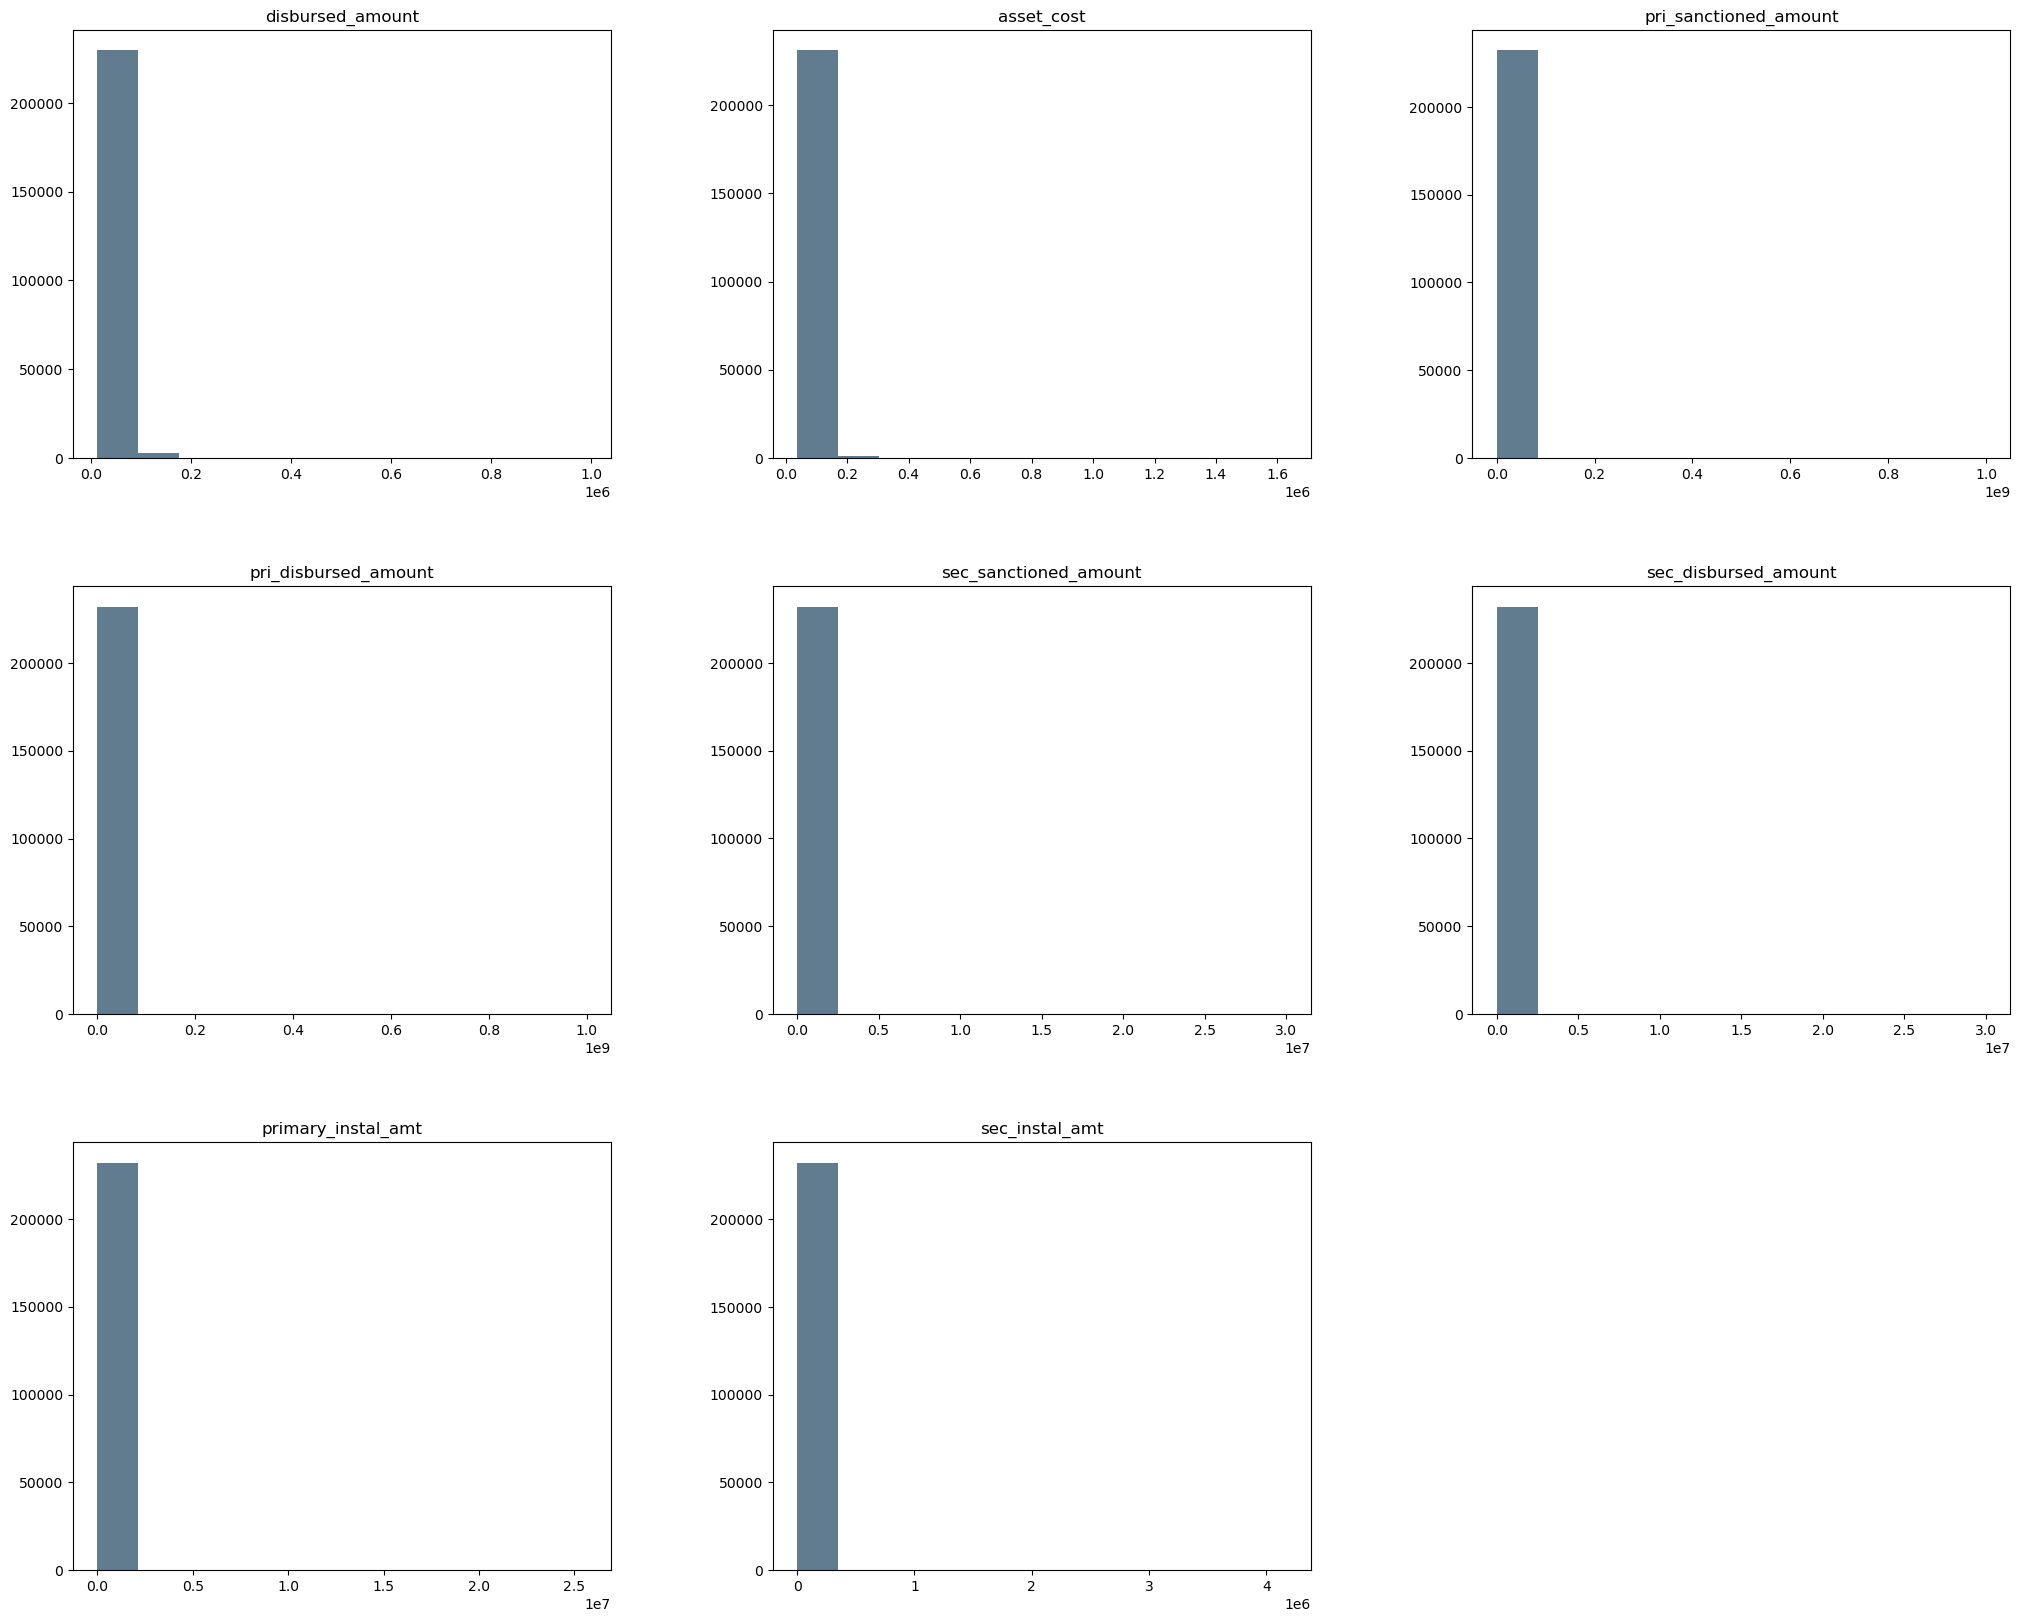

In [112]:
# We check the distributions of monetary fields to insepct if there are outliers
monetary_fields = ['disbursed_amount', 'asset_cost',
       'pri_sanctioned_amount', 'pri_disbursed_amount',
       'sec_sanctioned_amount', 'sec_disbursed_amount',
       'primary_instal_amt', 'sec_instal_amt']

df[monetary_fields].hist(bins=12, grid=False, figsize=(25,20), color='#607c8e', zorder=2, rwidth=3);

In [113]:
# We apply flooring to monetary variables apart from current balance so that the log transformation can be applied
# The floor is 1
df[['pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']] = np.where(
df[['pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']]<=0, 1, df[['pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']])


In [114]:
# Check that flooring has been applied correctly
df[['disbursed_amount', 'asset_cost', 'pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']].min()

disbursed_amount         13320
asset_cost               37000
pri_sanctioned_amount        1
pri_disbursed_amount         1
sec_sanctioned_amount        1
sec_disbursed_amount         1
primary_instal_amt           1
sec_instal_amt               1
dtype: int64

In [115]:
# We apply the log transformation
monetary_fields = ['disbursed_amount', 'asset_cost', 'pri_sanctioned_amount', 'pri_disbursed_amount',
    'sec_sanctioned_amount', 'sec_disbursed_amount','primary_instal_amt', 'sec_instal_amt']

for field in monetary_fields:
    df['log_' + field] = np.log(df[field])

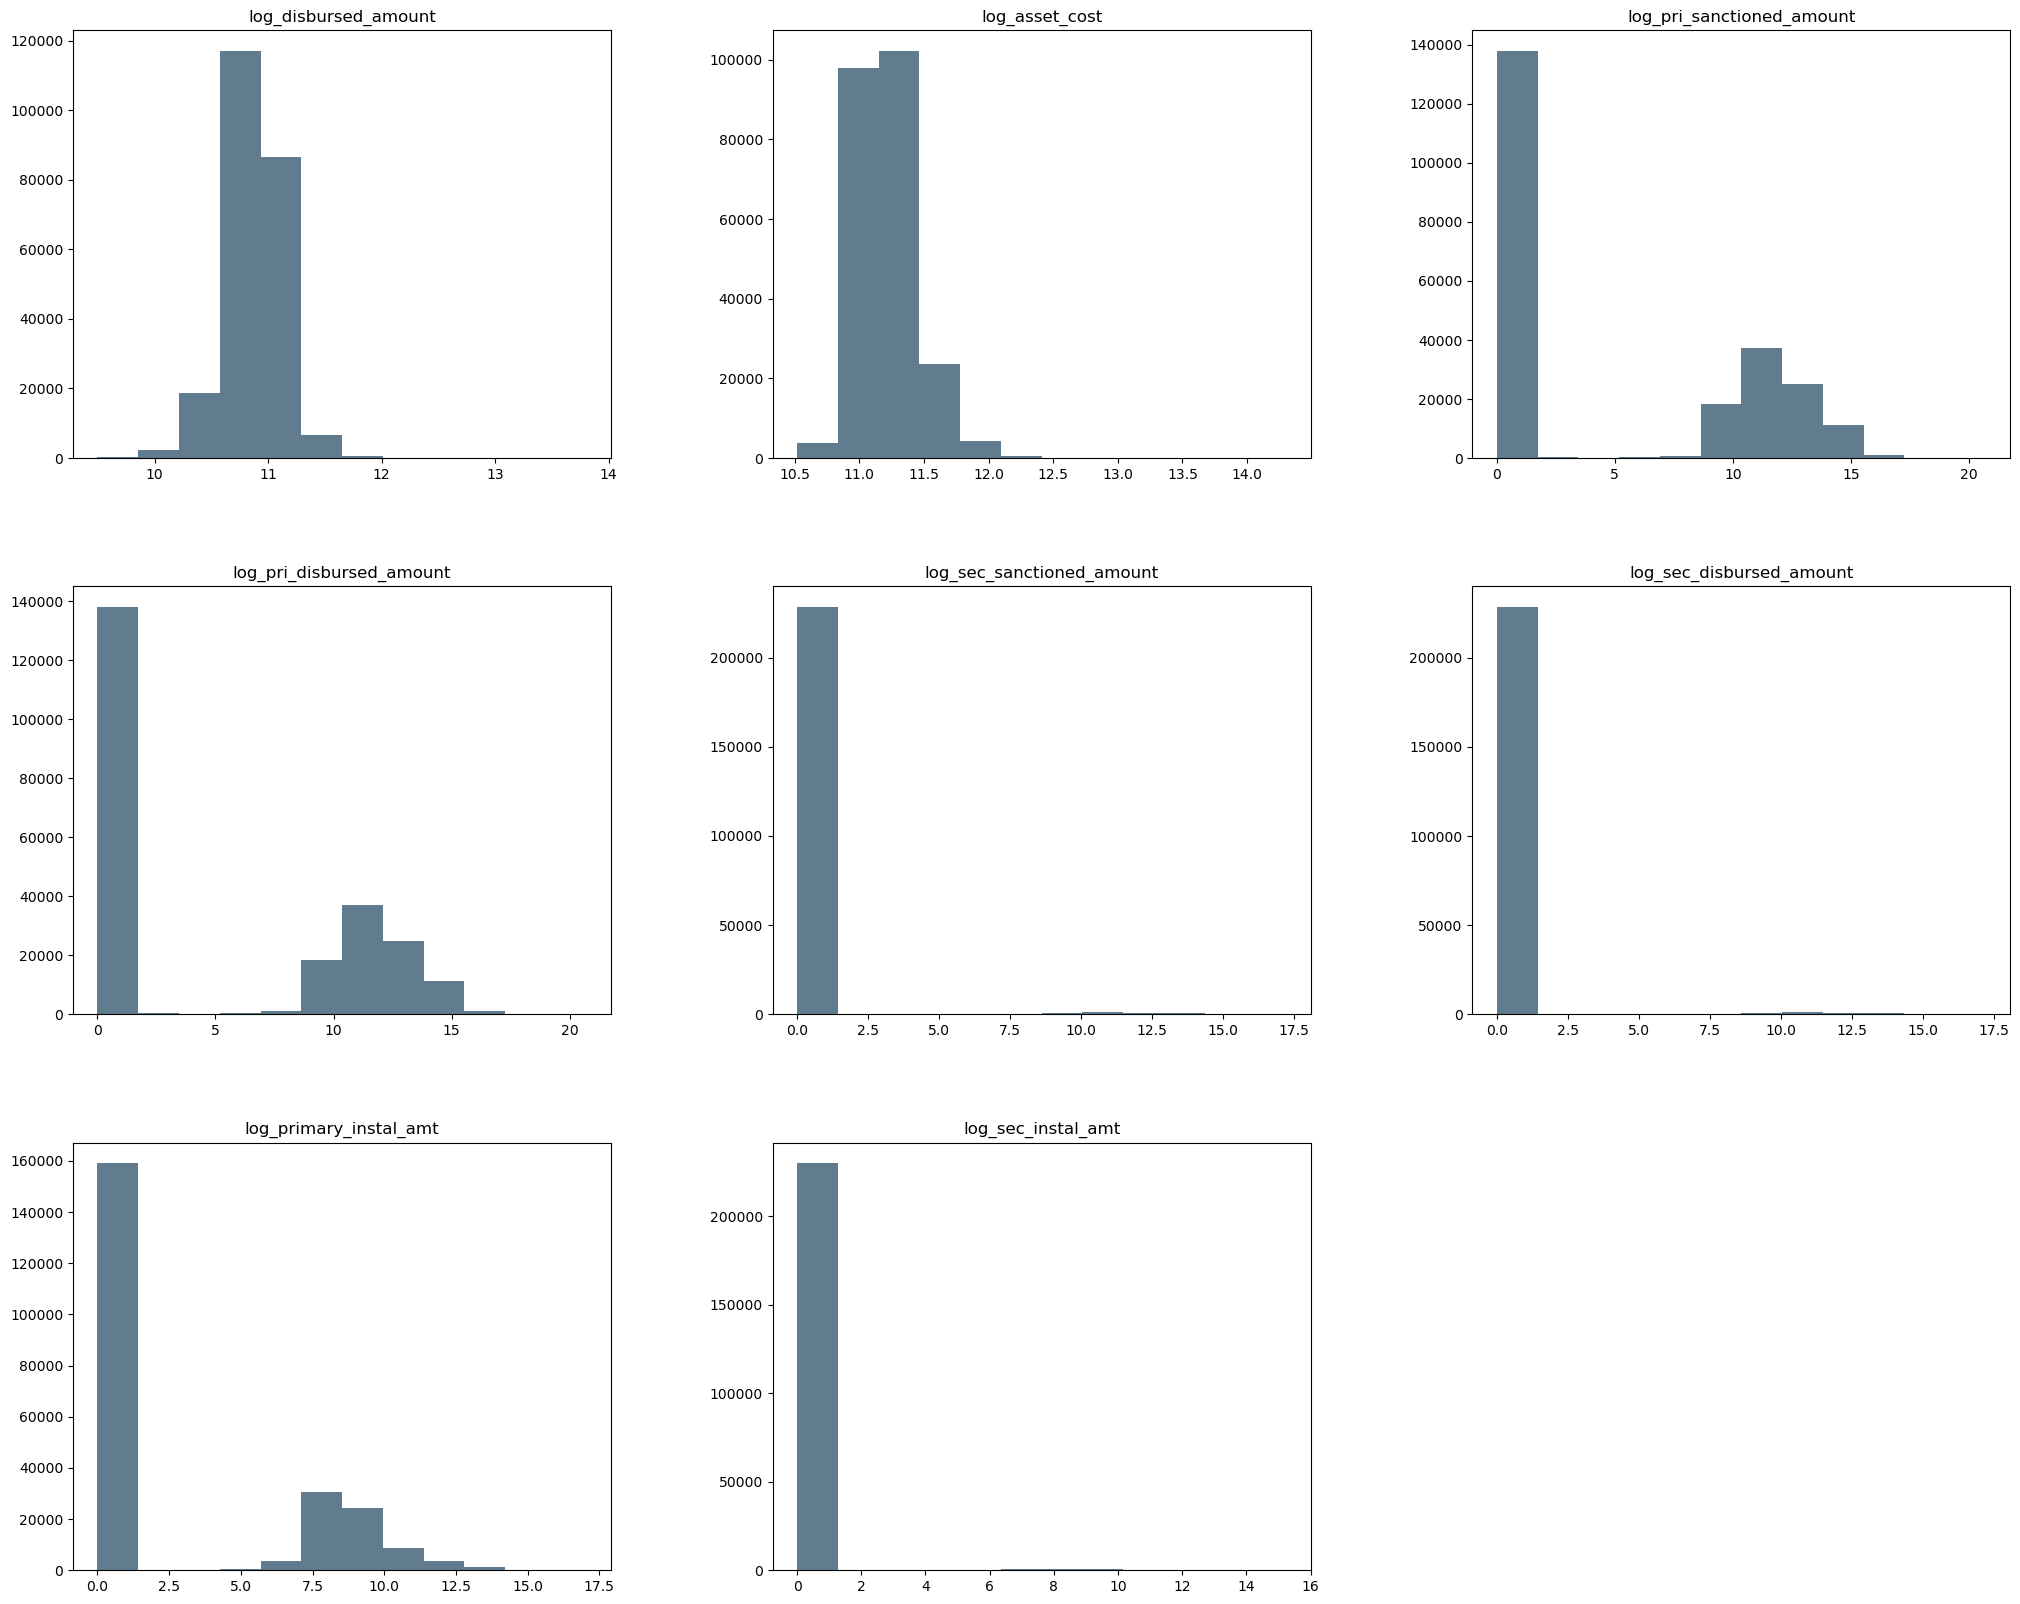

In [116]:
# Now we re-check their distributions
log_monetary_fields = ['log_disbursed_amount', 'log_asset_cost',
       'log_pri_sanctioned_amount', 'log_pri_disbursed_amount',
       'log_sec_sanctioned_amount', 'log_sec_disbursed_amount',
       'log_primary_instal_amt', 'log_sec_instal_amt']

df[log_monetary_fields].hist(bins=12, grid=False, figsize=(25,20), color='#607c8e', zorder=2, rwidth=3);

# The log transformation reduces the impact of certain outliers but not entirely

## 3.3. Identifying further outliers

Outliers skew the mean value which might lead to inaccurate conclusions. We can address outliers by winsorising them  or keeping them unchanged depending on whether there is a reasoning for having these values.

In [117]:
display(df.describe())
len(df)

,uniqueid,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,current_pincode_id,state_id,employee_code_id,mobileno_avl_flag,aadhar_flag,pan_flag,voterid_flag,driving_flag,passport_flag,perform_cns_score,pri_no_of_accts,pri_active_accts,pri_overdue_accts,pri_current_balance,pri_sanctioned_amount,pri_disbursed_amount,sec_no_of_accts,sec_active_accts,sec_overdue_accts,sec_current_balance,sec_sanctioned_amount,sec_disbursed_amount,primary_instal_amt,sec_instal_amt,new_accts_in_last_six_months,delinquent_accts_in_last_six_months,credit_history_length,no_of_inquiries,loan_default,obligor_age,avg_account_age,self_employed,salaried,no_employment_info,log_disbursed_amount,log_asset_cost,log_pri_sanctioned_amount,log_pri_disbursed_amount,log_sec_sanctioned_amount,log_sec_disbursed_amount,log_primary_instal_amt,log_sec_instal_amt
count,232146.000000,232146.00000,2.321460e+05,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.0,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,2.321460e+05,2.321460e+05,2.321460e+05,232146.000000,232146.000000,232146.000000,2.321460e+05,2.321460e+05,2.321460e+05,2.321460e+05,2.321460e+05,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000
mean,535926.554061,54341.28168,7.584118e+04,74.747698,72.899671,19641.154924,69.027750,3397.138969,7.260134,1549.727447,1.0,0.839967,0.075707,0.145245,0.023283,0.002128,288.385219,2.423048,1.033759,0.155307,1.648545e+05,2.171655e+05,2.167207e+05,0.055840,0.025958,0.006729,5.144322e+03,6.874261e+03,6.765844e+03,1.288011e+04,3.123974e+02,0.380032,0.096797,15.975093,0.206116,0.216898,34.008206,8.787698,0.549133,0.420464,0.030403,10.876134,11.212882,4.757930,4.740854,0.176813,0.174032,2.775896,0.079612
std,68317.217163,12963.32925,1.892312e+04,11.457998,69.842373,3491.719986,22.142233,2239.745016,4.481261,975.293032,0.0,0.366637,0.264529,0.352348,0.150800,0.046081,338.305640,5.189486,1.934227,0.547278,9.395186e+05,2.377291e+06,2.380233e+06,0.586483,0.293794,0.105370,1.679584e+05,1.793506e+05,1.788875e+05,1.482836e+05,1.548243e+04,0.950921,0.382577,28.051709,0.705918,0.412133,9.804680,14.849592,0.497581,0.493635,0.171695,0.234768,0.206496,5.865132,5.854538,1.430751,1.416077,4.193625,0.841656
min,417428.000000,13320.00000,3.700000e+04,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,-5.746470e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,9.497022,10.518673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,476799.250000,47145.00000,6.570900e+04,68.880000,14.000000,16555.000000,48.000000,1511.000000,4.000000,713.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,10.760983,11.092991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,535983.500000,53803.00000,7.093300e+04,76.800000,61.000000,20333.000000,86.000000,2966.000000,6.000000,1451.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,1.000000,0.000000,0.000000,10.893085,11.169491,0.000000,0.000000,0.000000,0.000

232146

As we can see, most variables have a large variation between mean and max values. We can visualise them using box plots for further analysis.

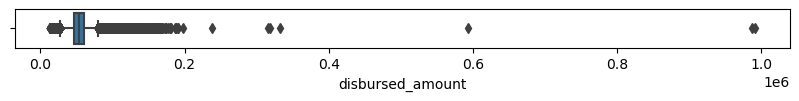

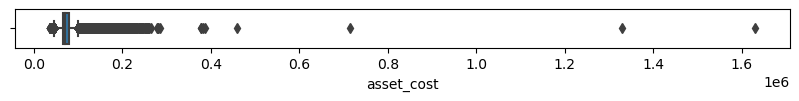

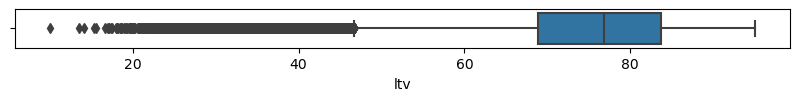

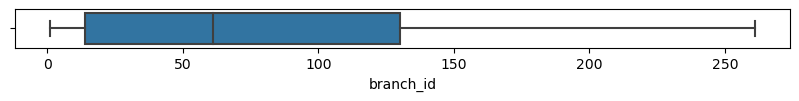

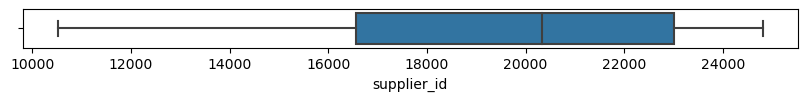

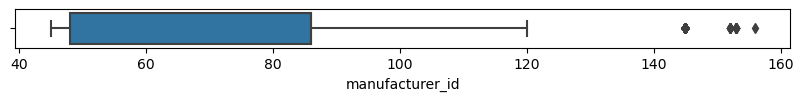

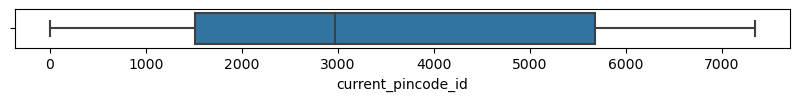

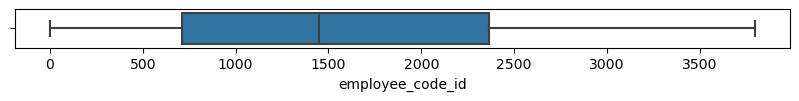

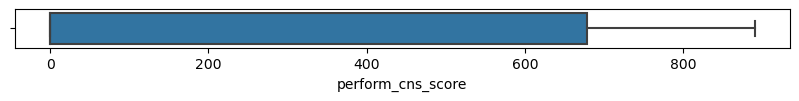

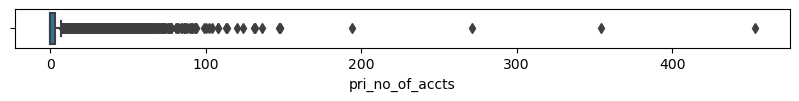

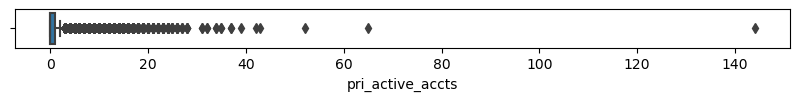

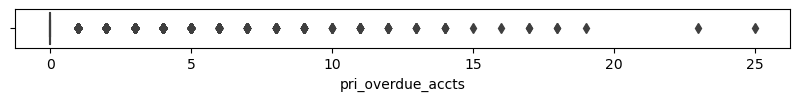

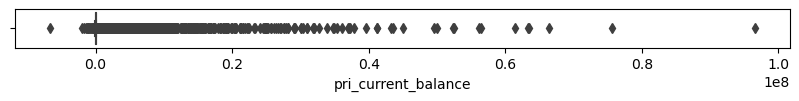

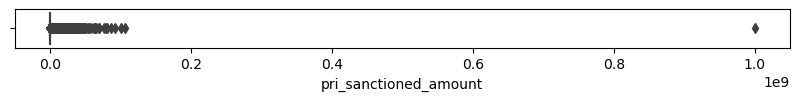

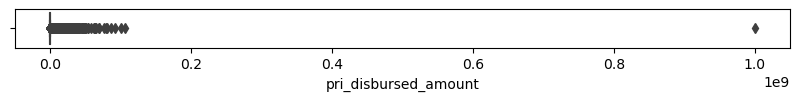

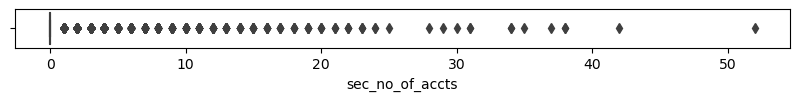

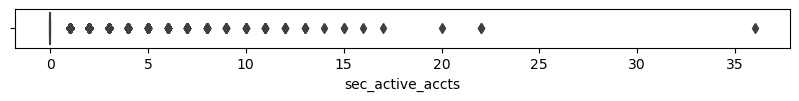

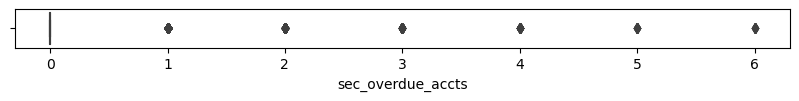

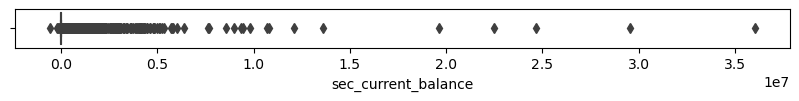

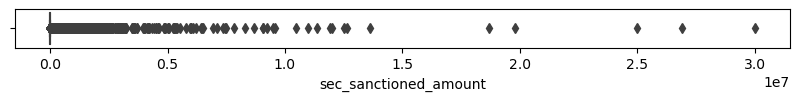

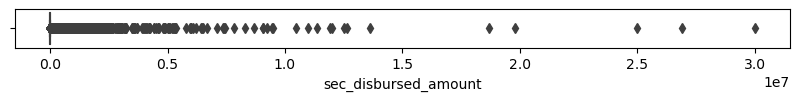

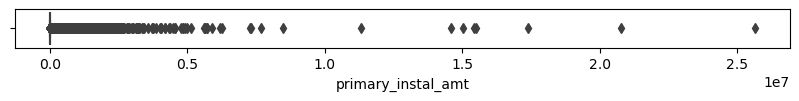

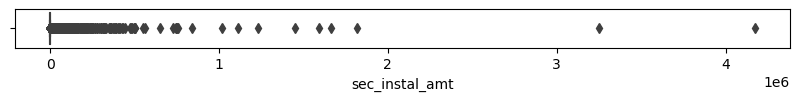

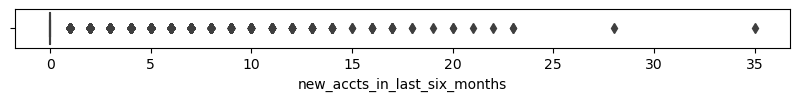

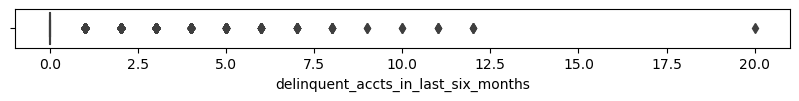

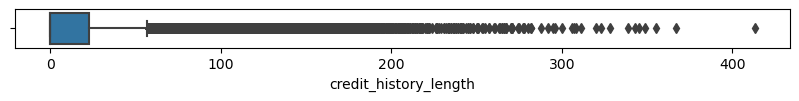

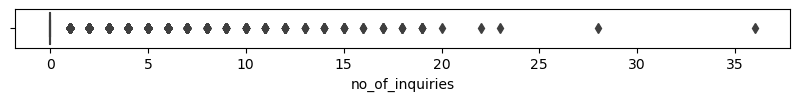

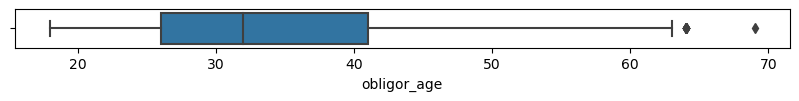

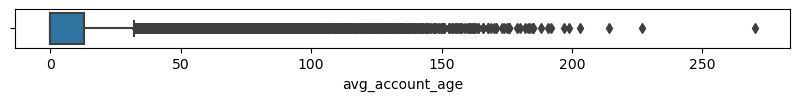

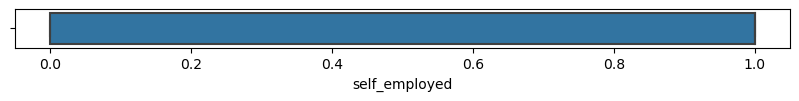

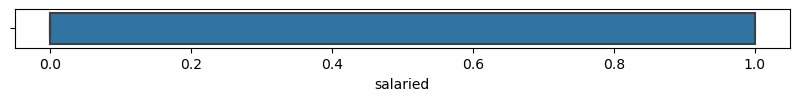

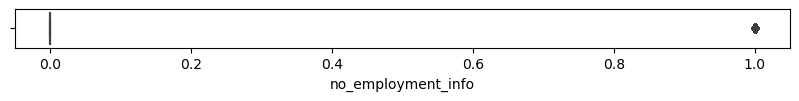

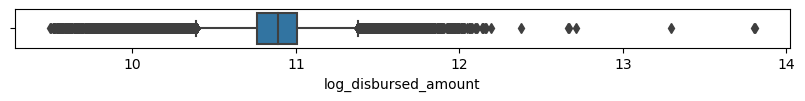

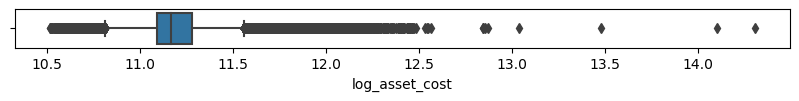

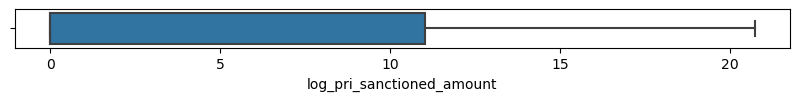

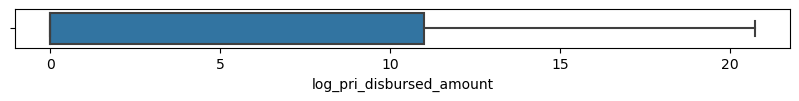

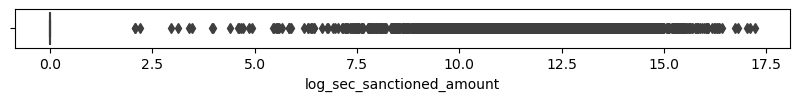

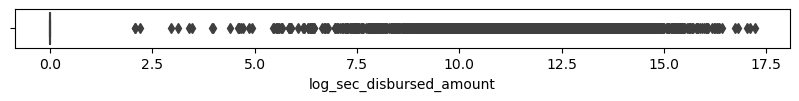

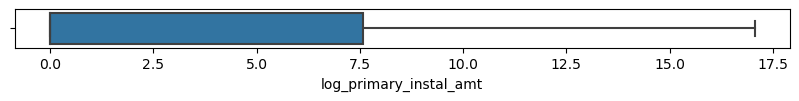

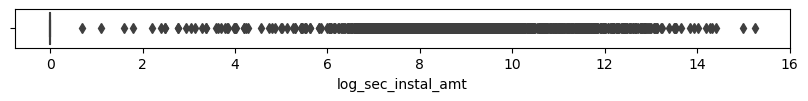

In [118]:
%matplotlib inline
warnings.filterwarnings("ignore")

df_box = df.copy()
df_box=df.select_dtypes(exclude=['object','datetime64[ns]'])
df_box = df_box.drop(["uniqueid","state_id","mobileno_avl_flag","aadhar_flag","pan_flag","driving_flag","voterid_flag","passport_flag","loan_default"], axis=1)
# We drop the variables that are not required for the identification of the outliers 
for column in df_box:
    size = plt.figure(figsize=(10,0.5))
    box = sns.boxplot(data=df_box, x=column);   

Wee can see that most variables in the dataset have outliers. The box plots for the **disbursed_amount** and **asset_cost** variables are graphically similar and have the majority of outliers in the upper extreme.

In [121]:
# Average account age and credit history length are characterised by extreme outliers
# Values will be capped to the 95th percentile

variables_to_winsorise_account = ['credit_history_length', 'avg_account_age']

variables_to_winsorise_monetary = ['disbursed_amount', 'asset_cost',
                         'pri_no_of_accts', 'pri_overdue_accts', 'pri_sanctioned_amount', 'pri_disbursed_amount',
                         'sec_no_of_accts', 'sec_overdue_accts', 'sec_sanctioned_amount', 'sec_disbursed_amount']

# Ignoring chained assignment error message
pd.options.mode.chained_assignment = None

for var in variables_to_winsorise_account:
    winsorise(df, var, percentile_upper = 0.95, cap_only = True)

# We chose a different percentile as a cap for monetary fields
for var in variables_to_winsorise_monetary:
    winsorise(df, var, percentile_upper = 0.995, cap_only = True)

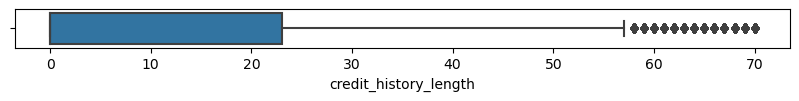

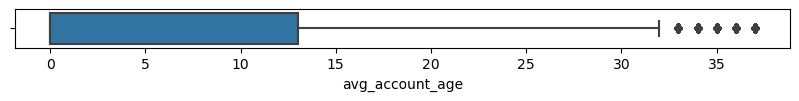

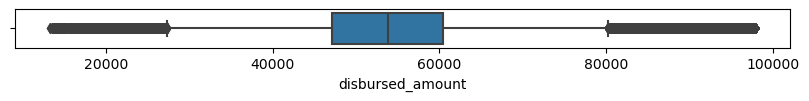

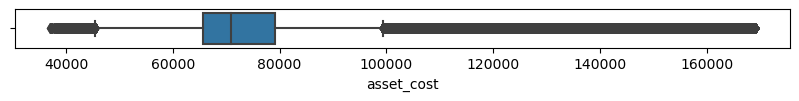

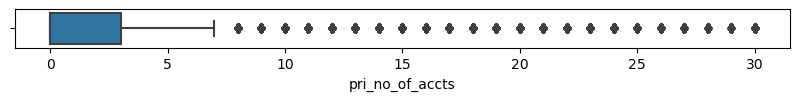

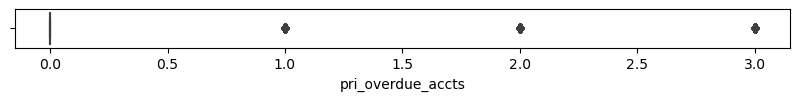

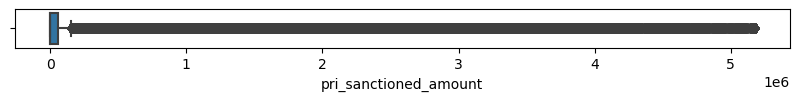

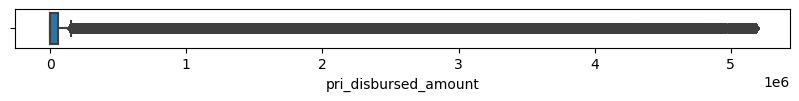

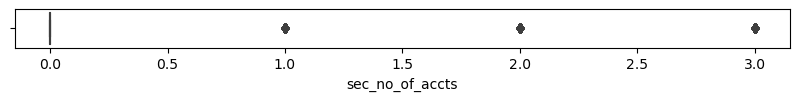

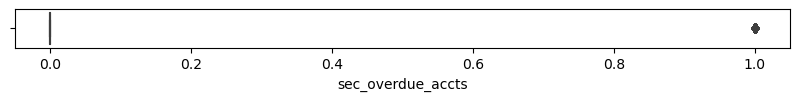

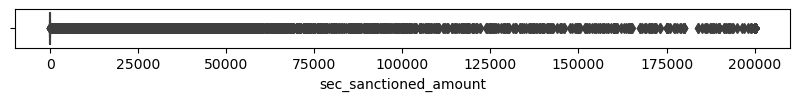

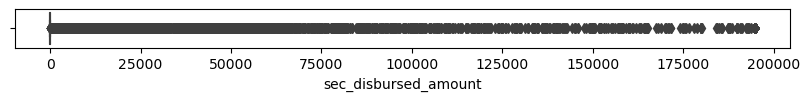

In [124]:
# Re-check boxplots of the two variables in question
for var in variables_to_winsorise_account:
    size = plt.figure(figsize=(10,0.5))
    box = sns.boxplot(data=df, x=var)
    
for var in variables_to_winsorise_monetary:
    size = plt.figure(figsize=(10,0.5))
    box = sns.boxplot(data=df, x=var)

# 3.4. Analysis by Attribute

There are several variables which might be spuriously correlated with loan defaults. They require further analysis.

These include **State_ID**,**branch_id**,**supplier_id**,**manufacturer_id**,**Current_pincode_ID**,**Employee_code_ID** and the different documentation flags. 

In [125]:
categorical_variables = ["state_id","branch_id", "supplier_id","manufacturer_id","current_pincode_id","employee_code_id", "no_of_inquiries", "employment_type"]
df[categorical_variables].describe()

,state_id,branch_id,supplier_id,manufacturer_id,current_pincode_id,employee_code_id,no_of_inquiries
count,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000,232146.000000
mean,7.260134,72.899671,19641.154924,69.027750,3397.138969,1549.727447,0.206116
std,4.481261,69.842373,3491.719986,22.142233,2239.745016,975.293032,0.705918
min,1.000000,1.000000,10524.000000,45.000000,1.000000,1.000000,0.000000
25%,4.000000,14.000000,16555.000000,48.000000,1511.000000,713.000000,0.000000
50%,6.000000,61.000000,20333.000000,86.000000,2966.000000,1451.000000,0.000000
75%,10.000000,130.000000,23000.000000,86.000000,5680.000000,2363.000000,0.000000
max,22.000000,261.000000,24803.000000,156.000000,7345.000000,3795.000000,36.000000


## State_ID

In [126]:
# Setting the dimensions of the plot
plt.rcParams['figure.figsize'] = (7, 3)

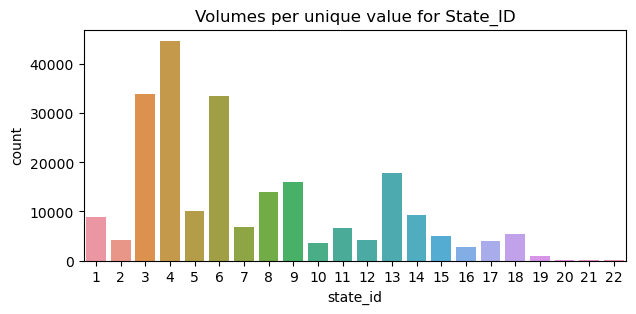

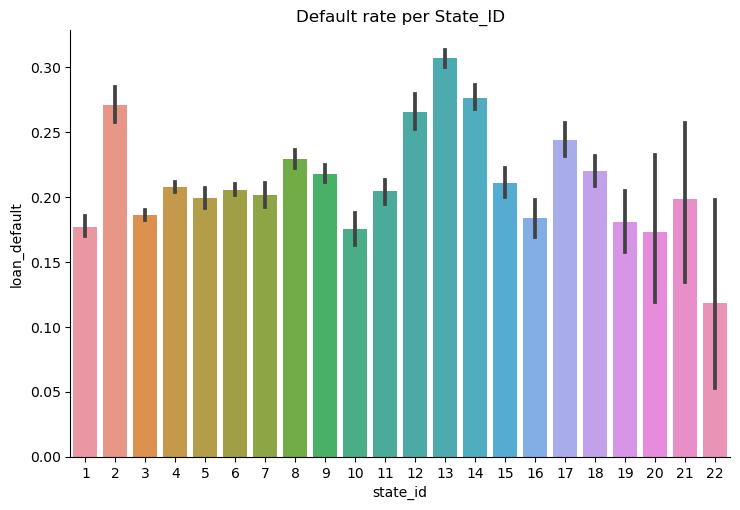

In [127]:
# Plotting the volume and the default rate per categorical variable
sns.countplot(data = df, x=df["state_id"])
plt.title("Volumes per unique value for State_ID");

sns.catplot(data = df, x = "state_id", y='loan_default',
               kind= 'bar', aspect=1.5);
plt.title("Default rate per State_ID");
plt.show();

States 2, 12,13 and 14 have abnormally high default rates, while state 22 has abnormally an low default rate. However, the first chart shows that those states also have few observations, thus, causing volatile values. 

Controlling for that all, the other states seem to be distributed amongst the dataset mean of 21.7% default rate. A strong relationship with the outcome variable cannot be definitely established.

## Branch ID (Current Pincode and Employee_code_ID)
The **branch_id** is also problematic as there is no way to tie it to a state. There are 82 different branches and they are not correlated with loan default. The variable is dropped from the dataset. 

With the above rationale, we also exclude **current_pincode**, **employee_code_id**, **supplier_id** and **manufacturer_id** from our dataset as they are too specific to yield relevant insides. 

In [128]:
# Dropping the column branch_id
df = df.drop(["branch_id","current_pincode_id","employee_code_id","manufacturer_id","supplier_id"], axis=1)

## Number of Inquiries

Number of inquiries should be positively correlated with loan default.

However, the chart below demonstrates that there very few entries with more than four enquiries causing the relationship with the default rate to be volatile.

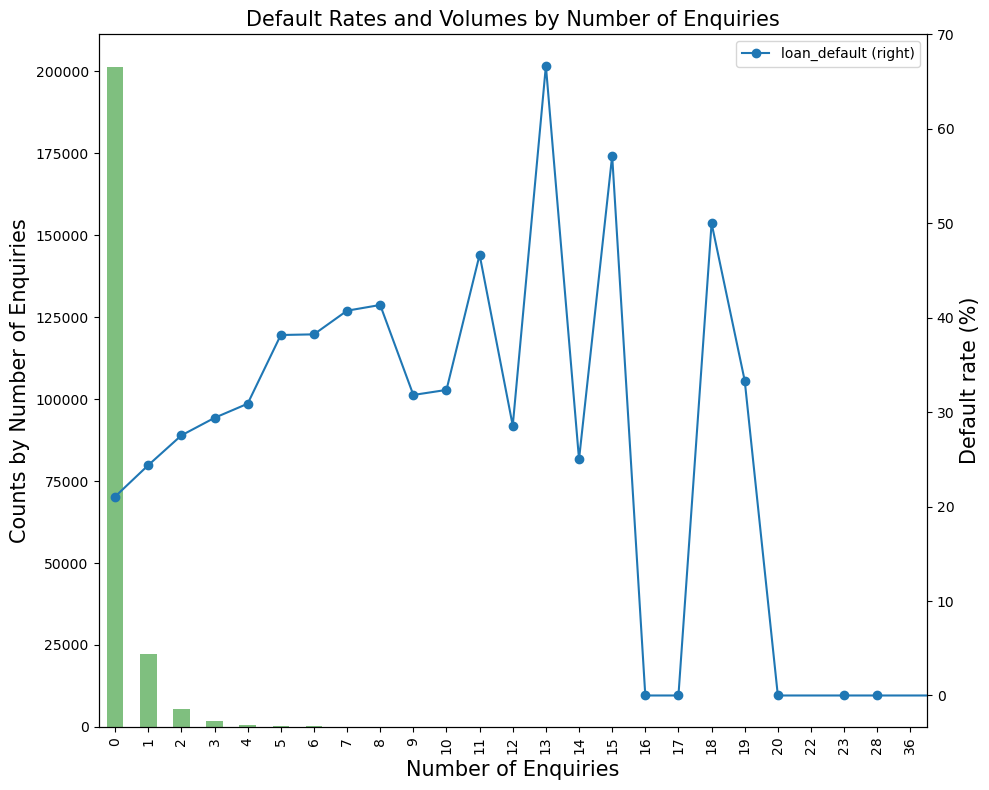

In [131]:
# Default rate by number of enquiries
defaults_by_no = df.groupby(['no_of_inquiries'])['loan_default'].sum()
counts_by_no = df.groupby(['no_of_inquiries'])['loan_default'].count()
avg_default_rate_no = (defaults_by_no / counts_by_no) * 100

plt.figure(figsize=(10,8))
default_rate = avg_default_rate_no.plot(kind='line', marker="o", secondary_y = True)

#Add a second axis to show the number of counts in each LTV bin
volumes = counts_by_no.plot(kind='bar', color='g', alpha=0.5, label = 'Volumes')

plt.title('Default Rates and Volumes by Number of Enquiries', size=15)
plt.xticks(rotation = 45)
default_rate.set_ylabel('Default rate (%)', size= 15)
volumes.set_ylabel('Counts by Number of Enquiries', size= 15)
volumes.set_xlabel('Number of Enquiries', size= 15)
plt.legend()
plt.tight_layout()
plt.show();

###  Employment Type

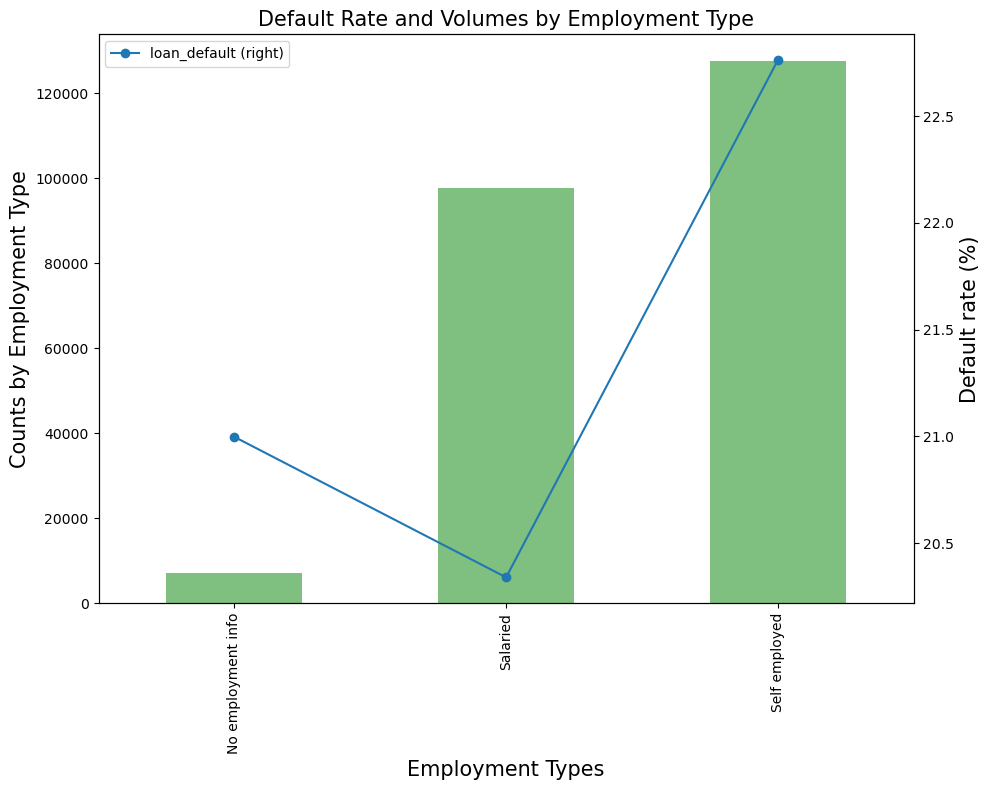

In [143]:
# Default rate by employment type
defaults_by_emp = df.groupby(['employment_type'])['loan_default'].sum()
counts_by_emp = df.groupby(['employment_type'])['loan_default'].count()
avg_default_rate_emp = (defaults_by_emp / counts_by_emp) * 100

plt.figure(figsize=(10,8))
default_rate = avg_default_rate_emp.plot(kind='line', marker="o", secondary_y = True)

#Add a second axis to show the number of counts in each LTV bin
volumes = counts_by_emp.plot(kind='bar', color='g', alpha=0.5, label = 'Volumes')

plt.title('Default Rate and Volumes by Employment Type', size=15)
default_rate.set_ylabel('Default rate (%)', size= 15)
volumes.set_ylabel('Counts by Employment Type', size= 15)
volumes.set_xlabel('Employment Types', size= 15)
plt.legend()
plt.tight_layout()
plt.show();

**Employment type** should be correlated with loan defaults as it affects income and ability to repay debt but there is actually no significant difference. The "no-eployment-info" category could suggest lack of income or just missing information as the default rate for "no-eployment-info" is not higher than the rest.

## Documentation Flags

There are  different forms of documentation in the dataset that were accepted by the lender which made us analyse the the default rates per form of ID provided.

In [145]:
# We create a new column recording the total number of documentation provided by each obligor 
# to examine the relationship between the number of documentations and likelihood of loan default.

# We make sure every obligor provided at least one form of documentation.

# Checking whether each obligor provided sufficient documentation. No one provided no form of ID. 
df["number_ID_provided"] = df[['aadhar_flag','pan_flag','voterid_flag','driving_flag', 'passport_flag']].sum(axis=1)
len(df.loc[df["number_ID_provided"]<1])

0

###  ID Type 

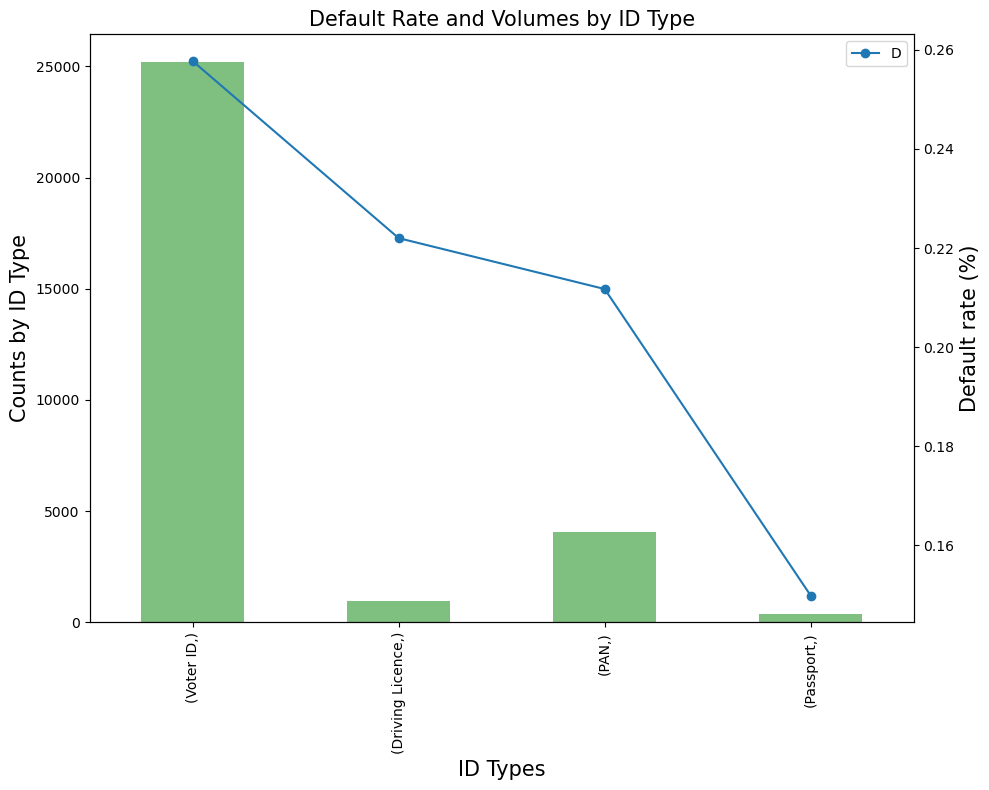

In [147]:
# Default rate by employment type
counts_by_ID = [len(df.loc[(df["number_ID_provided"]==1)&(df["voterid_flag"]==1)]),len(df.loc[(df["number_ID_provided"]==1)&(df["pan_flag"]==1)]),
                len(df.loc[(df["number_ID_provided"]==1)&(df["driving_flag"]==1)]),len(df.loc[(df["number_ID_provided"]==1)&(df["passport_flag"]==1)])]
defaults_by_ID = [len(df.loc[(df["number_ID_provided"]==1)&(df["voterid_flag"]==1)&(df["loan_default"]==1)]),
                  len(df.loc[(df["number_ID_provided"]==1)&(df["pan_flag"]==1)&(df["loan_default"]==1)]),
                len(df.loc[(df["number_ID_provided"]==1)&(df["driving_flag"]==1)&(df["loan_default"]==1)]),
                  len(df.loc[(df["number_ID_provided"]==1)&(df["passport_flag"]==1)&(df["loan_default"]==1)])]
avg_default_by_documentation = [defaults_by_ID[i]/counts_by_ID[i] for i in range(len(counts_by_ID))]

avg_default_by_documentation = pd.Series(avg_default_by_documentation,index=[["Voter ID","Driving Licence","PAN","Passport"]])
counts_by_ID = pd.Series(counts_by_ID,index=[["Voter ID","Driving Licence","PAN","Passport"]])

plt.figure(figsize=(10,8))
default_rate = avg_default_by_documentation.plot(kind='line', marker="o", secondary_y = True)

#Add a second axis to show the number of counts in each LTV bin
volumes = counts_by_ID.plot(kind='bar', color='g', alpha=0.5, label = 'Volumes')

plt.title('Default Rate and Volumes by ID Type', size=15)
default_rate.set_ylabel('Default rate (%)', size= 15)
volumes.set_ylabel('Counts by ID Type', size= 15)
volumes.set_xlabel('ID Types', size= 15)
plt.legend("Default rate")
plt.tight_layout()
plt.show();

There is no indication that someone who only provided a passsport is a safer obligor because the number of people who only provided a passport is so small. Again we can draw no strong conclusion from ID types.

## LTV bins

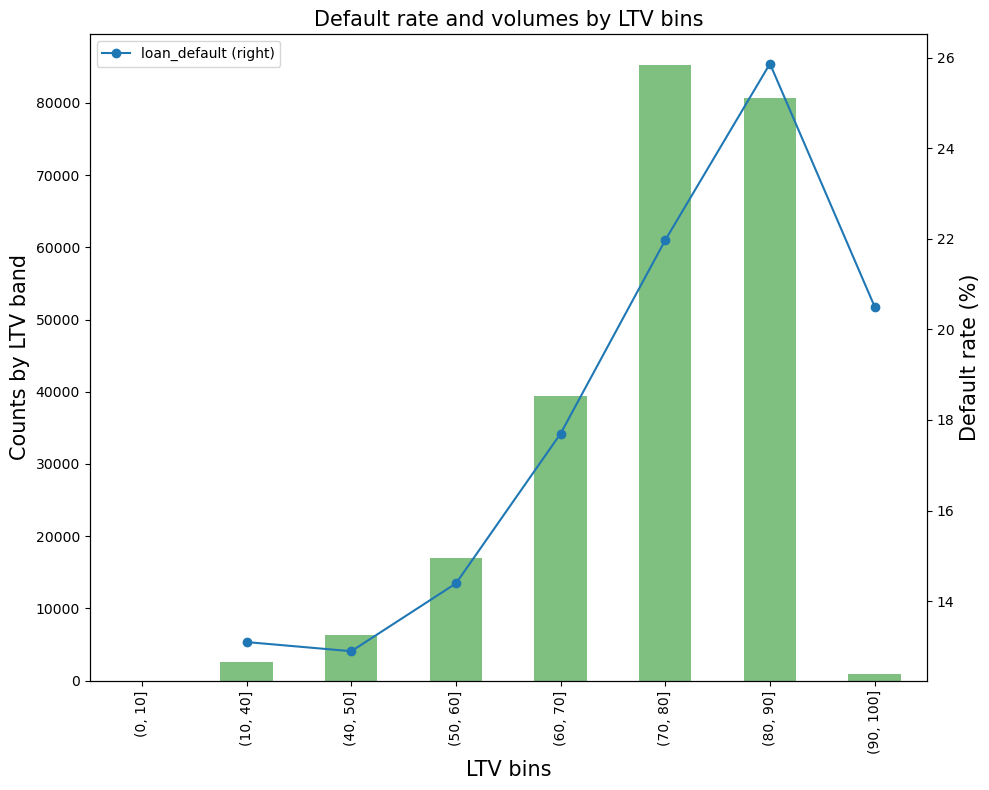

In [46]:
# Default rate by ltv bins
df['binned_ltv'] = pd.cut(df['ltv'], [0, 10, 40, 50, 60, 70, 80, 90,100],  duplicates='drop')

defaults_by_ltv = df.groupby(['binned_ltv'])['loan_default'].sum()
counts_by_ltv = df.groupby(['binned_ltv'])['loan_default'].count()
avg_default_rate_ltv = (defaults_by_ltv / counts_by_ltv) * 100

plt.figure(figsize=(10,8))
default_rate = avg_default_rate_ltv.plot(kind='line', marker="o", secondary_y = True)

#Add a second axis to show the number of counts in each LTV bin
volumes = counts_by_ltv.plot(kind='bar', color='g', alpha=0.5, label = 'Volumes')

plt.title('Default rate and volumes by LTV bins', size=15)
plt.xticks(rotation = 45)
default_rate.set_ylabel('Default rate (%)', size= 15)
volumes.set_ylabel('Counts by LTV band', size= 15)
volumes.set_xlabel('LTV bins', size= 15)
plt.legend()
plt.tight_layout()
plt.show();

We can observe the rising pattern and a positive relationship between the default rate and loan-to-value (LTV) rate. The highest default rate of 28% is in the ltv range from 83.67% to 85% LTV.

## Credit score bins

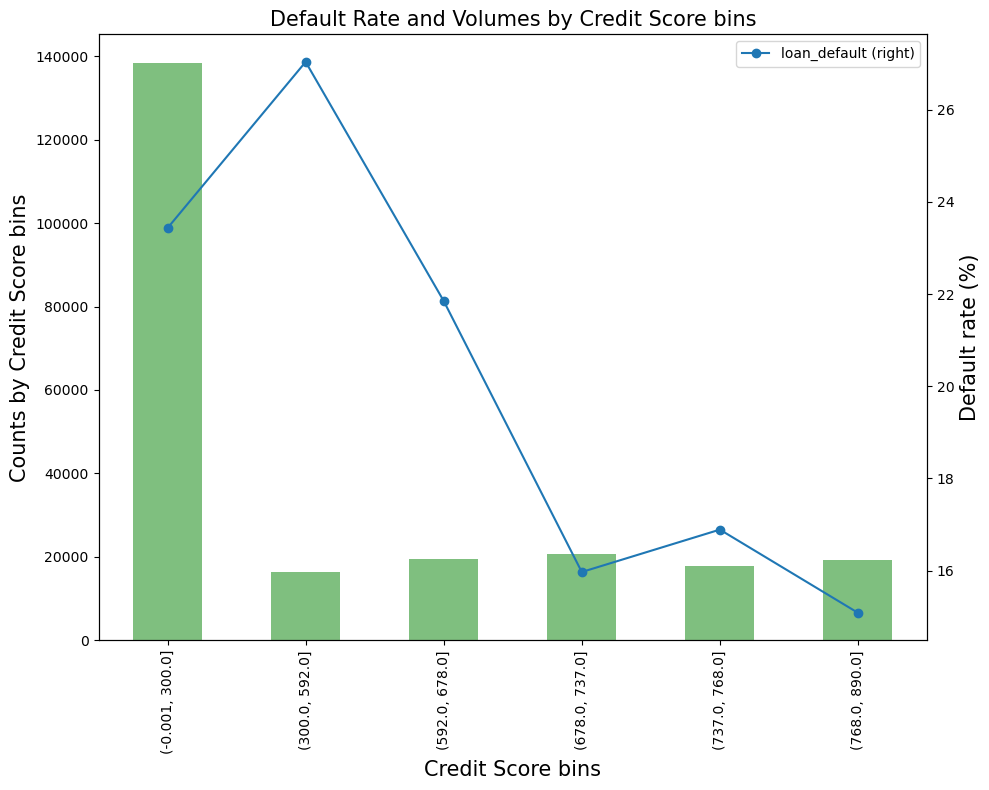

In [148]:
# Default rate by credit score bins
df['binned_credit_score'] = pd.qcut(df['perform_cns_score'], 12,  duplicates='drop')
defaults_by_credit_score = df.groupby(['binned_credit_score'])['loan_default'].sum()
counts_by_credit_score = df.groupby(['binned_credit_score'])['loan_default'].count()
avg_default_rate_credit_score = (defaults_by_credit_score / counts_by_credit_score) * 100

plt.figure(figsize=(10,8))
default_rate = avg_default_rate_credit_score.plot(kind='line', marker="o", secondary_y = True)

#Add a second axis to show the number of counts in each LTV bin
volumes = counts_by_credit_score.plot(kind='bar', color='g', alpha=0.5, label = 'Volumes')

plt.title('Default Rate and Volumes by Credit Score bins', size=15)
plt.xticks(rotation = 45)
default_rate.set_ylabel('Default rate (%)', size= 15)
volumes.set_ylabel('Counts by Credit Score bins', size= 15)
volumes.set_xlabel('Credit Score bins', size= 15)
plt.legend()
plt.tight_layout()
plt.show();

The group of customers with the credit score ranging from 300 to 592 have the highest default rate, while the second highest default rate attributes to the borrowers with the credit score in the range of -0.001 to 300. The declining trend within the graph can be explained by the inverse relationship between credit score and default risk.

## Credit score description

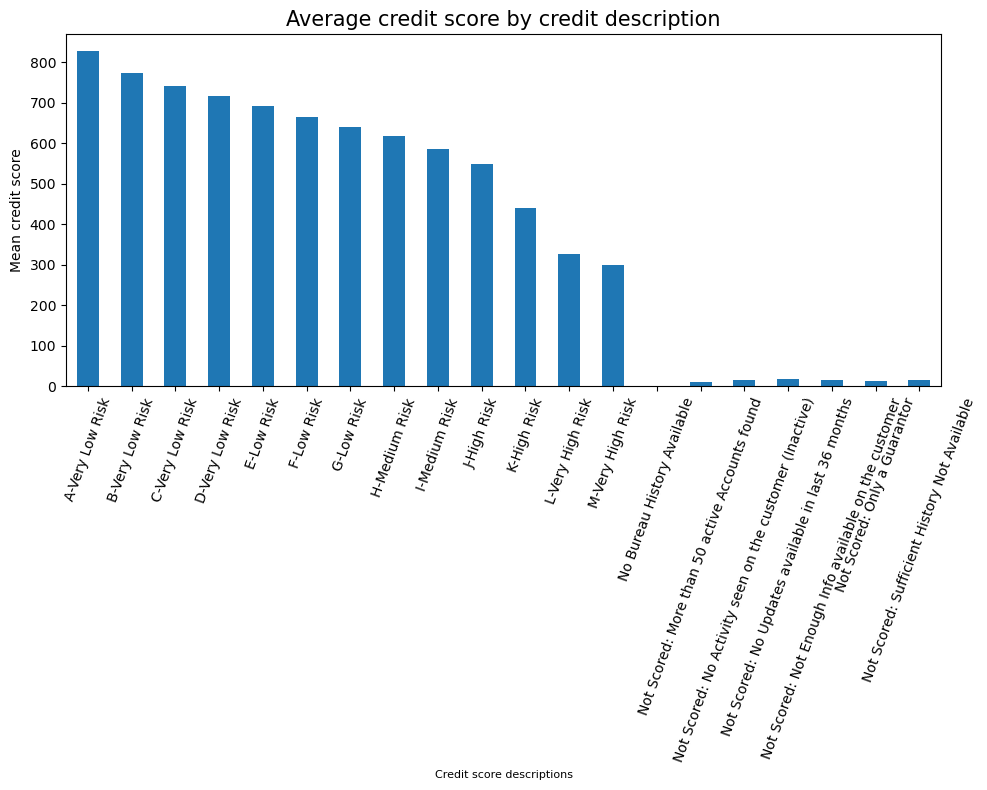

In [55]:
plt.figure(figsize=(10,8))
avg_credit_score_by_description = df.groupby(['perform_cns_score_description'])['perform_cns_score'].mean()
avg_credit_score_by_description.plot(kind='bar')
plt.title('Average credit score by credit description', size=15)
plt.xlabel('Credit score descriptions', size= 8)
plt.xticks(rotation = 70)
plt.ylabel('Mean credit score', size= 10)
plt.tight_layout()
plt.show();

We calculate the average credit score within the different credit score descriptions. The safer category of customers have a higher credit score.

The customers that have not scored points in the dataset are separately grouped by reasons for the absence of credit scores.

In [150]:
# More than 50% of the observations have no Bureau history!!
prop_by_credit_score_descriptions = (df.groupby(['perform_cns_score_description'])['uniqueid'].count() / len(df)) * 100
display(prop_by_credit_score_descriptions)

perform_cns_score_description
A-Very Low Risk                                             6.042318
B-Very Low Risk                                             3.941054
C-Very Low Risk                                             6.878861
D-Very Low Risk                                             4.856427
E-Low Risk                                                  2.481197
F-Low Risk                                                  3.621428
G-Low Risk                                                  1.701515
H-Medium Risk                                               2.919284
I-Medium Risk                                               2.369199
J-High Risk                                                 1.592102
K-High Risk                                                 3.531398
L-Very High Risk                                            0.481593
M-Very High Risk                                            3.730842
No Bureau History Available                                50.354949
Not 

## Histograms by default status 

The histograms below suggest that the distribution of performing and defaulted obligors is not very different for the given variables. This suggests that loan defaults are not strongly related with any of those variables. This goes against our initial expectations and indicates that the data lacks the relevant risk drivers or its quality is poor. 

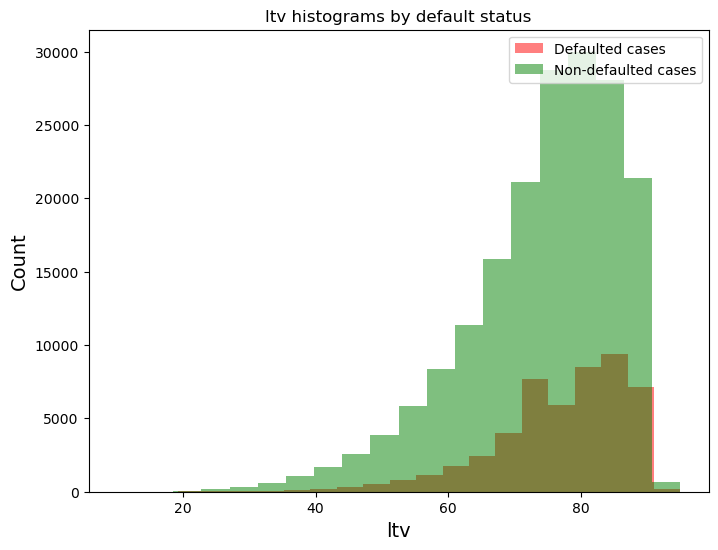

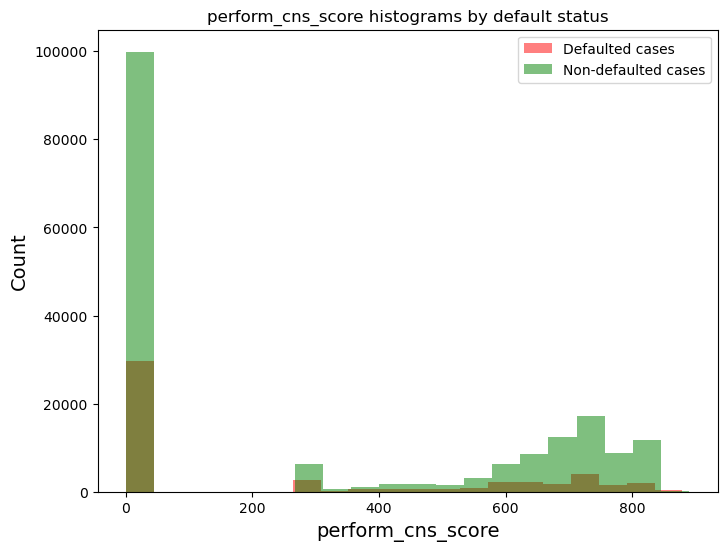

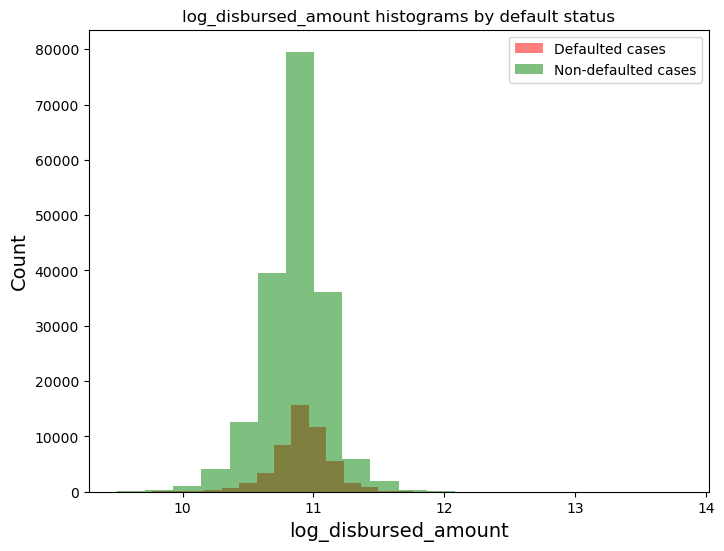

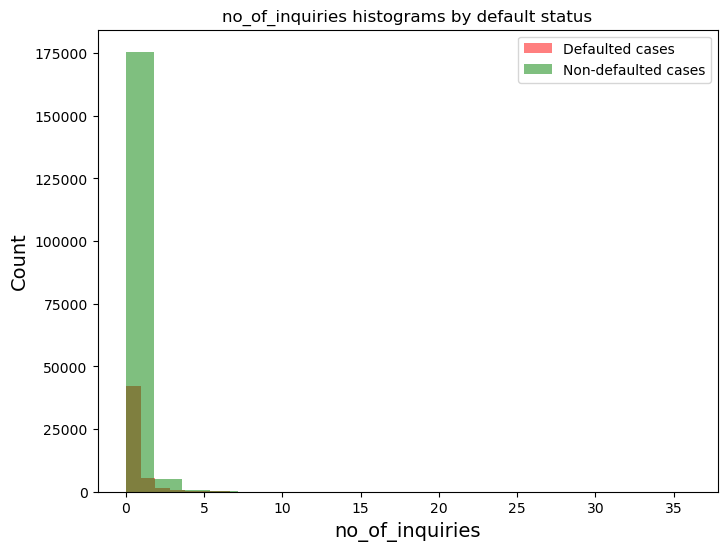

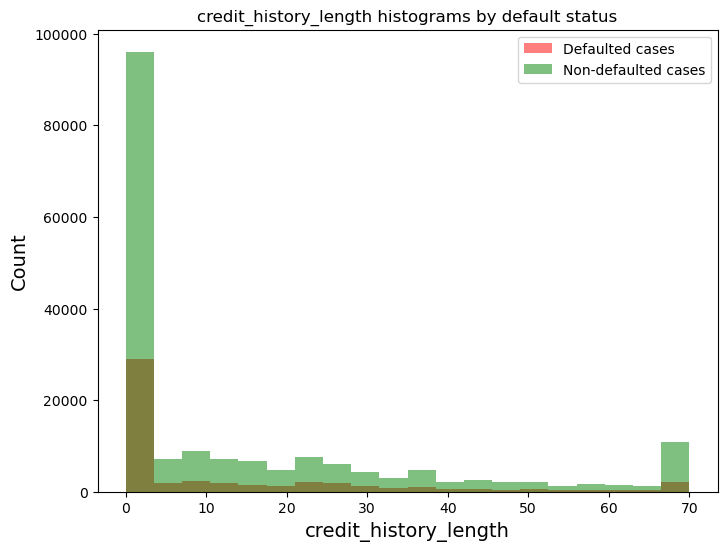

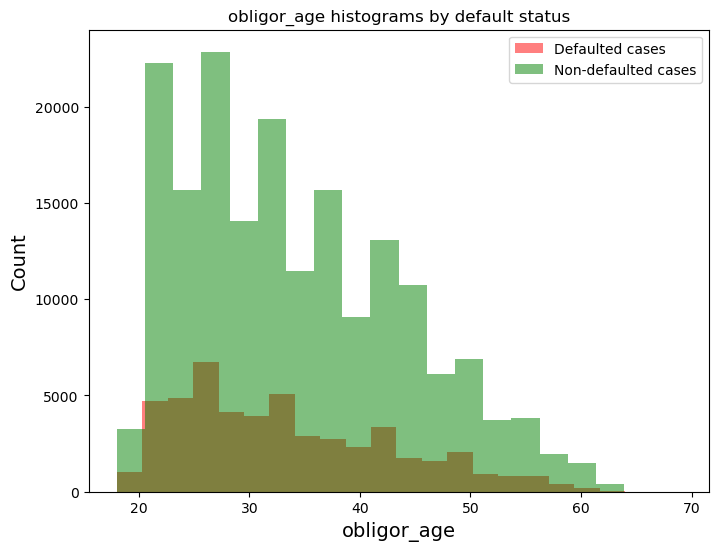

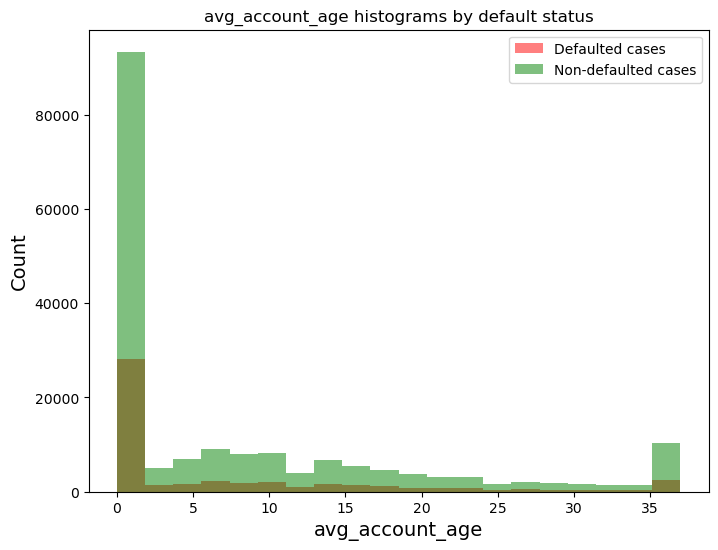

In [187]:
# Define list of plots
variables_for_histograms = ['ltv', 'perform_cns_score', 'log_disbursed_amount', 'no_of_inquiries', 
                            'credit_history_length', 'obligor_age', 'avg_account_age']

# Call plotting function to generate histograms
for variable in variables_for_histograms:
    default_histogram(df,variable, bin_no = 20);

# 3.5. EDA Summary

This analysis has shown that key indicators for loan defaults such as **LTV** and **credit score** are relevant in our dataset. However, the data  lacks the correlation strength with the outcome variable loan default. 

We believe that fitting a predictive model will likely lead to inaccurate results.

###  Heatmap 2.0 

In [189]:
# Our EDA narrowed down our list of relevant predictors which are shown in an update correlation matrix.
corr_matrix_new = df.copy()
corr_matrix_new= corr_matrix_new.drop(columns = ['uniqueid', 'disbursed_amount', 'asset_cost',
                                'pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount',
                                'sec_current_balance', 'sec_sanctioned_amount', 'sec_disbursed_amount',
                                'primary_instal_amt', 'sec_instal_amt', 'employment_type', 'date_of_birth', 
                                'disbursaldate', 'state_id', 'perform_cns_score_description',
                                'mobileno_avl_flag', 'aadhar_flag', 'pan_flag', 'voterid_flag', 'driving_flag',
                                'passport_flag', 'self_employed', 'salaried', 'no_employment_info'])

In [190]:
# Round the correlation values with respect to our predicted value "loan_default" in our matrix to 2 digits to make them easier to read.
corr_matrix_new = corr_matrix_new.corr().round(2)
corr_matrix_new["loan_default"].sort_values(ascending=False)

loan_default                           1.00
ltv                                    0.10
log_disbursed_amount                   0.09
pri_overdue_accts                      0.05
no_of_inquiries                        0.04
delinquent_accts_in_last_six_months    0.03
log_asset_cost                         0.02
number_ID_provided                    -0.00
sec_overdue_accts                     -0.00
sec_no_of_accts                       -0.01
sec_active_accts                      -0.01
log_sec_instal_amt                    -0.01
log_primary_instal_amt                -0.01
log_sec_disbursed_amount              -0.01
log_sec_sanctioned_amount             -0.01
log_pri_disbursed_amount              -0.03
new_accts_in_last_six_months          -0.03
avg_account_age                       -0.03
pri_no_of_accts                       -0.04
log_pri_sanctioned_amount             -0.04
pri_active_accts                      -0.04
credit_history_length                 -0.04
obligor_age                     

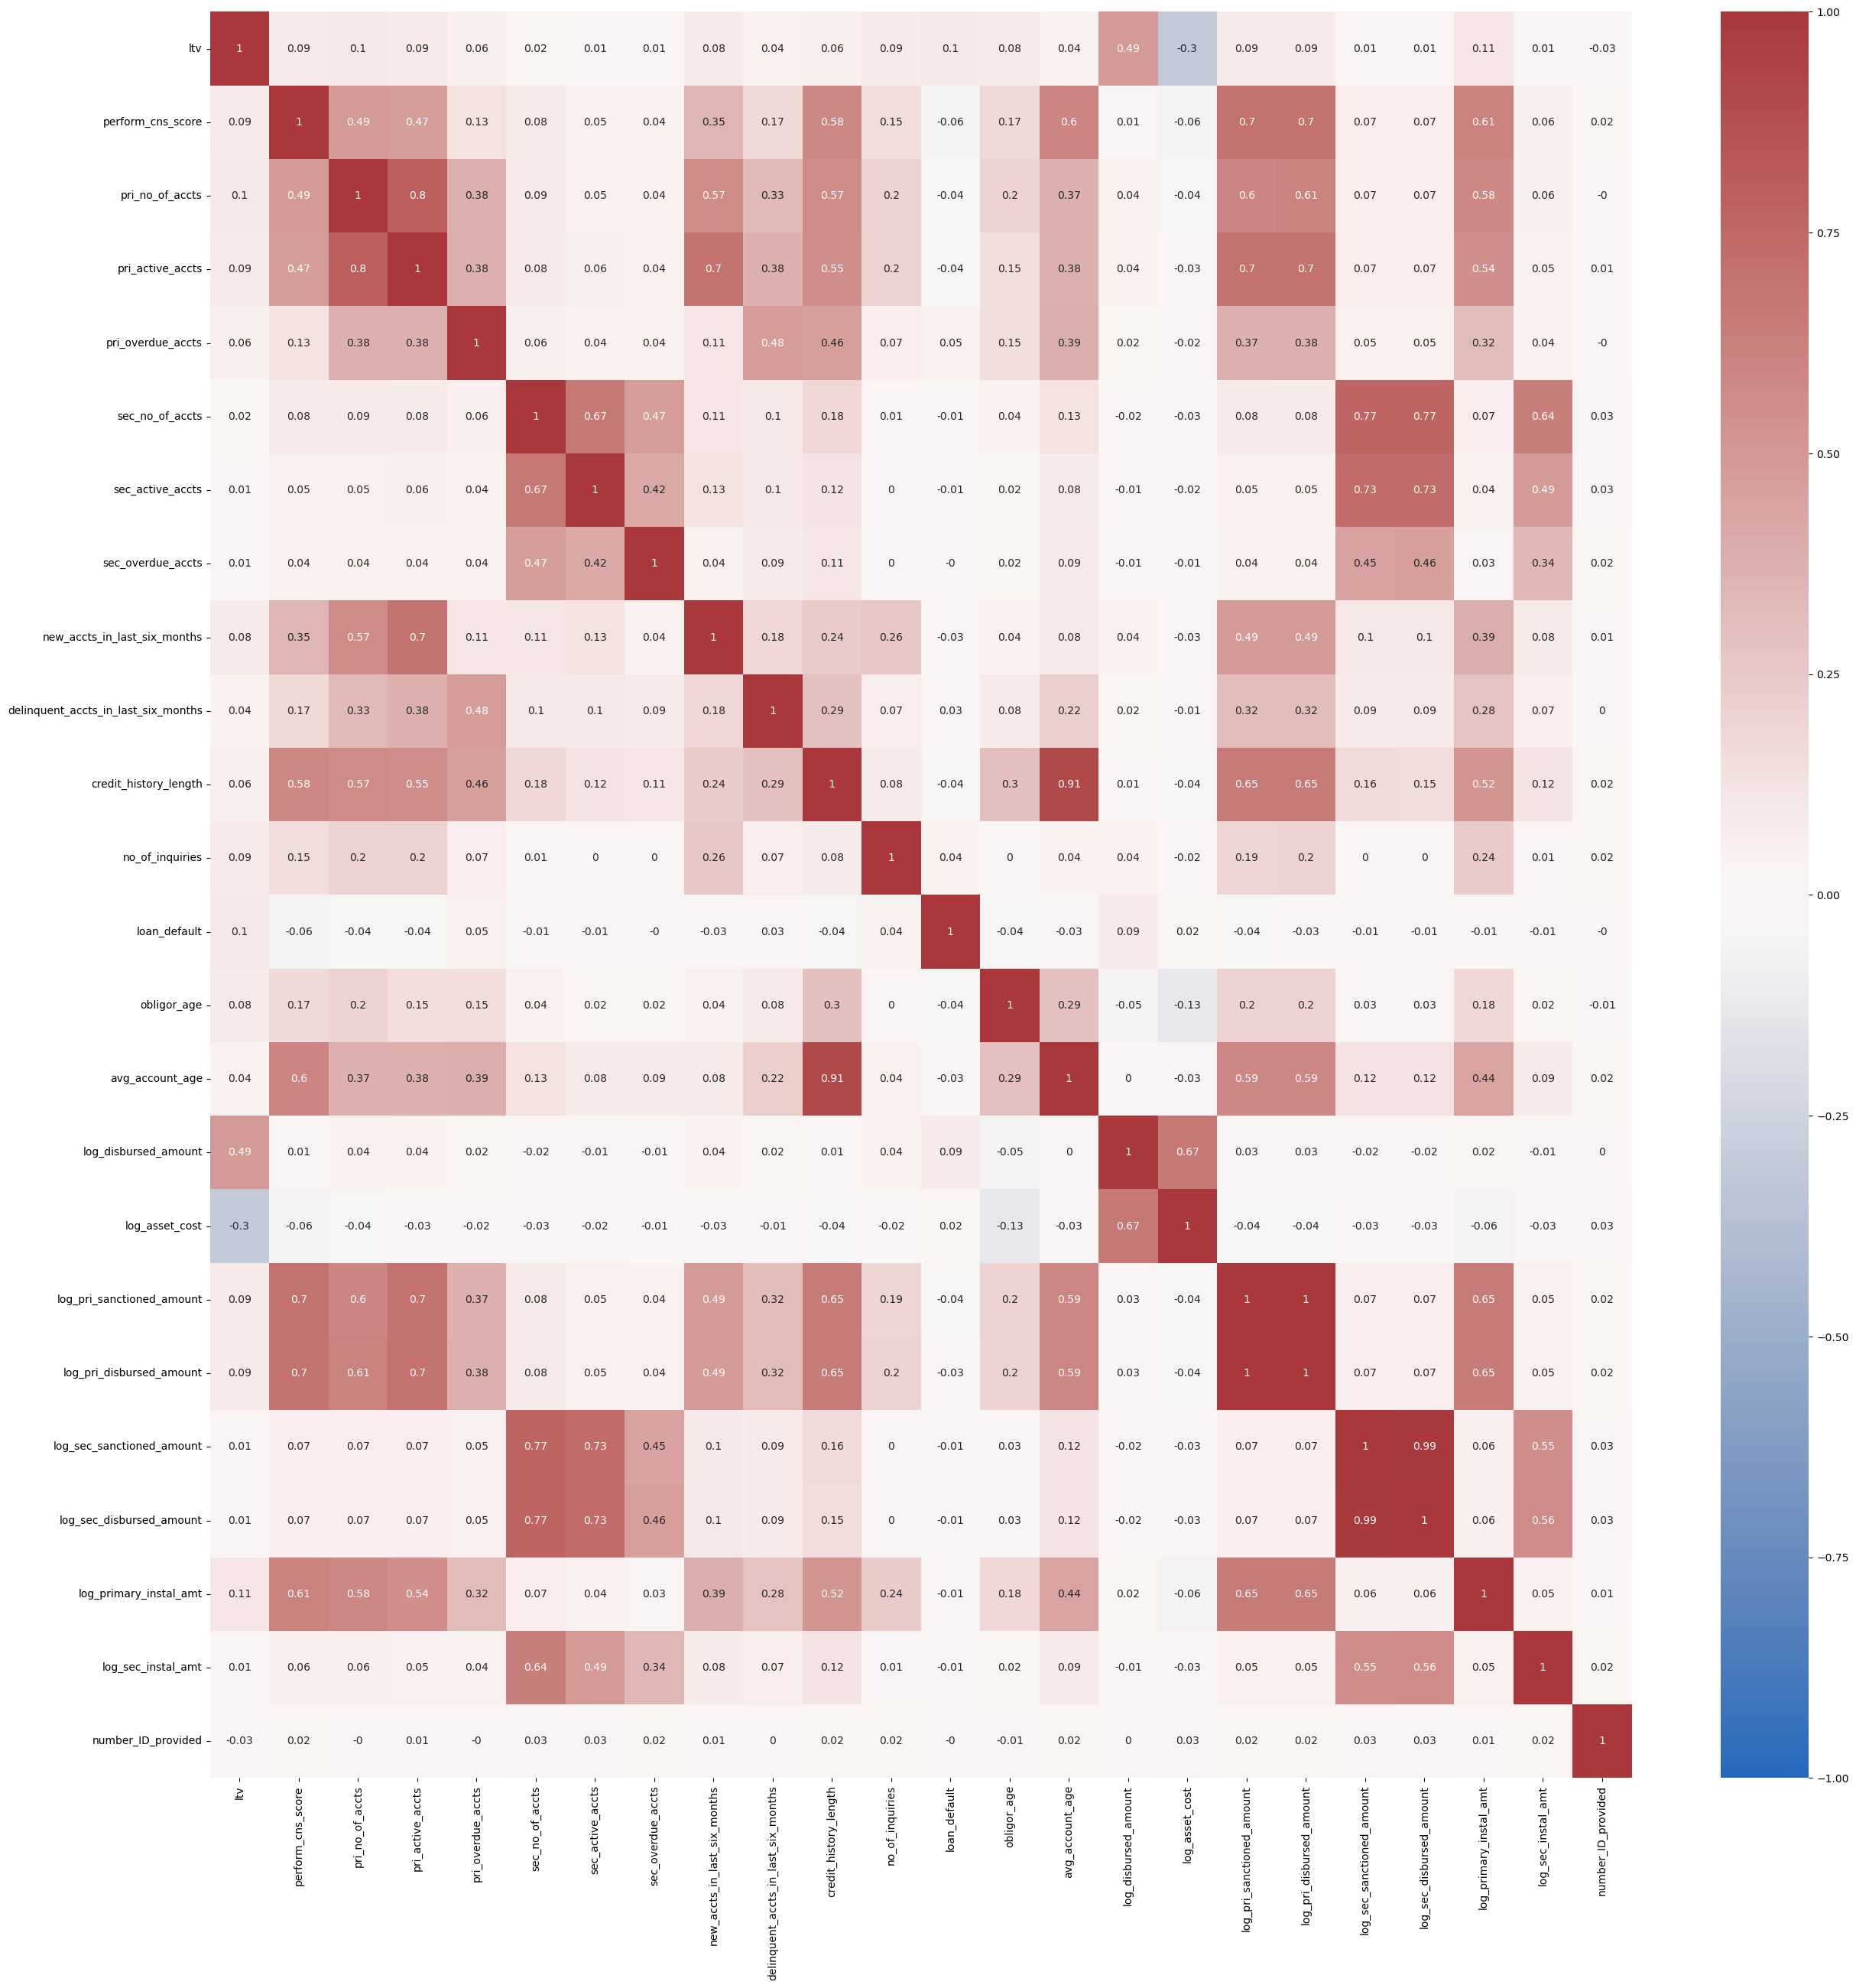

In [191]:
# Heatmap for our selected predictors
plt.figure(figsize=(30,30))
sns.heatmap(corr_matrix_new, cbar=True,annot=True, vmax=1, vmin=-1, center=0, cmap='vlag')
# plt.show()
plt.savefig('EDA_output/heatmap_v2.png');

# 4. Modelling

The Logistic regression is most commonly used to predict the **PD** because the outcome variable is binary and it is a relatively interpretable model. The functional specification is given below:

$$ P(Default) = \frac{1}{1+ exp(-α - β_1 * X_1 - β_2 * X_2 +  β_3 * X_3 + .. β_n * X_n)} $$

To select model variables, we used the following approaches:
1. Intuition from our understanding of the data.
2. Weight of Evidence and Information Value calculations (see below).
3. Stepwise Selection.

We also implement an XGboost algoritm to check if we can achieve a higher predictive accuracy. 

# 4.1. Weight of Evidence (WoE) & Information Value (IV)<a name="cite_ref-2"></a>[<sup>[2]</sup>](#cite_note-2)

Higher values indicate that the variables can differentiate between performing and defaulting customers.

Indicative value ranges:
- Less than 0.02 --> Not useful for prediction
- 0.02 to 0.1 --> Weak predictive Power
- 0.1 to 0.3 --> Medium predictive Power
- 0.3 to 0.5 --> Strong predictive Power
- Higher than 0.5 --> Suspicious Predictive Power

In [155]:
# We show the WoE and IV for each categorical and numerical variable and then a summary table of all IVs.

# Discrete variables first
discrete_features_for_WoE = ['employment_type', 'no_of_inquiries', 'number_ID_provided', 'state_id']
discrete_WoE = []

for variable in discrete_features_for_WoE:
    print("Calculating the WoE and Information Value for {}:".format(variable))
    woe = calc_woe_iv(df, variable, 'loan_default', print_full_results=1, continuous= False)
    discrete_WoE.append(woe)

discrete_WoE = pd.DataFrame(discrete_WoE, columns=['Risk driver', 'Information Value'])
discrete_WoE.sort_values(by=['Information Value'], ascending= False, inplace= True)
display(discrete_WoE)

Calculating the WoE and Information Value for employment_type:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
2,employment_type,No employment info,7058,1482,0.030403,0.209974,0.030672,0.029433,0.041243,0.004923
0,employment_type,Salaried,97609,19853,0.420464,0.203393,0.427715,0.394284,0.081385,0.004923
1,employment_type,Self employed,127479,29017,0.549133,0.227622,0.541613,0.576283,-0.062047,0.004923


Calculating the WoE and Information Value for no_of_inquiries:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,no_of_inquiries,0,201150,42356,0.866525,0.210569,0.873541,0.841198,0.037728,0.011789
1,no_of_inquiries,1,22157,5402,0.095449,0.243806,0.092171,0.107285,-0.151842,0.011789
3,no_of_inquiries,2,5371,1479,0.023137,0.275368,0.021410,0.029373,-0.316213,0.011789
4,no_of_inquiries,3,1752,515,0.007547,0.293950,0.006805,0.010228,-0.407492,0.011789
2,no_of_inquiries,4,751,232,0.003235,0.308921,0.002855,0.004608,-0.478603,0.011789
5,no_of_inquiries,5,338,129,0.001456,0.381657,0.001150,0.002562,-0.801248,0.011789
6,no_of_inquiries,6,238,91,0.001025,0.382353,0.000809,0.001807,-0.804197,0.011789
11,no_of_inquiries,7,135,55,0.000582,0.407407,0.000440,0.001092,-0.909076,0.011789
9,no_of_inquiries,8,104,43,0.000448,0.413462,0.000336,0.000854,-0.934096,0.011789
8,no_of_inquiries,9,44,14,0.000190,0.318182,0.000165,0.000278,-0.521630,0.011789


Calculating the WoE and Information Value for number_ID_provided:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,number_ID_provided,1,212439,46109,0.915109,0.217046,0.914937,0.915733,-0.000870,0.000144
1,number_ID_provided,2,19377,4188,0.083469,0.216133,0.083551,0.083174,0.004512,0.000144
2,number_ID_provided,3,326,54,0.001404,0.165644,0.001496,0.001072,0.332982,0.000144
3,number_ID_provided,4,4,1,0.000017,0.250000,0.000017,0.000020,-0.185224,0.000144


Calculating the WoE and Information Value for state_id:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
8,state_id,1,8886,1571,0.038278,0.176795,0.040238,0.031200,0.254379,0.038779
13,state_id,2,4143,1123,0.017847,0.271060,0.016612,0.022303,-0.294583,0.038779
2,state_id,3,33906,6310,0.146055,0.186103,0.151798,0.125318,0.191699,0.038779
1,state_id,4,44749,9298,0.192762,0.207781,0.195006,0.184660,0.054516,0.038779
4,state_id,5,10157,2019,0.043753,0.198779,0.044765,0.040098,0.110106,0.038779
0,state_id,6,33426,6865,0.143987,0.205379,0.146105,0.136340,0.069172,0.038779
15,state_id,7,6774,1366,0.029180,0.201653,0.029748,0.027129,0.092157,0.038779
17,state_id,8,13991,3210,0.060268,0.229433,0.059303,0.063751,-0.072321,0.038779
3,state_id,9,15958,3472,0.068741,0.217571,0.068682,0.068955,-0.003959,0.038779
5,state_id,10,3585,627,0.015443,0.174895,0.016271,0.012452,0.267486,0.038779


,Risk driver,Information Value
3,state_id,0.038779
1,no_of_inquiries,0.011789
0,employment_type,0.004923
2,number_ID_provided,0.000144


In [156]:
# Continuous variables now
continuous_features_for_WoE = ['ltv', 'disbursed_amount', 'perform_cns_score', 'pri_no_of_accts', 'pri_active_accts', 'pri_overdue_accts',
       'pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount',
       'sec_no_of_accts', 'sec_active_accts', 'sec_overdue_accts',
       'sec_current_balance', 'sec_sanctioned_amount', 'sec_disbursed_amount',
       'primary_instal_amt', 'sec_instal_amt', 'new_accts_in_last_six_months', 'obligor_age', 'credit_history_length']

continuous_WoE = []

for variable in continuous_features_for_WoE:
    print("Calculating the WoE and Information Value for {}:".format(variable))
    woe = calc_woe_iv(df, variable, 'loan_default', print_full_results=1, continuous= True, bins= 12)
    continuous_WoE.append(woe)
    
continuous_WoE = pd.DataFrame(continuous_WoE, columns=['Risk driver', 'Information Value'])
continuous_WoE.sort_values(by=['Information Value'], ascending= False, inplace= True)
display(continuous_WoE)

Calculating the WoE and Information Value for ltv:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
8,ltv,"(10.029, 57.1]",19350,2640,0.083353,0.136434,0.091917,0.052431,0.561393,0.066129
9,ltv,"(57.1, 64.32]",19343,3030,0.083323,0.156646,0.089733,0.060176,0.399564,0.066129
11,ltv,"(64.32, 68.88]",19354,3379,0.083370,0.174589,0.087874,0.067108,0.269609,0.066129
4,ltv,"(68.88, 72.3]",19352,3809,0.083361,0.196827,0.085498,0.075647,0.122408,0.066129
1,ltv,"(72.3, 74.55]",19443,4176,0.083753,0.214782,0.083980,0.082936,0.012504,0.066129
3,ltv,"(74.55, 76.8]",19245,4131,0.082900,0.214653,0.083138,0.082042,0.013266,0.066129
10,ltv,"(76.8, 79.15]",19398,4247,0.083559,0.218940,0.083342,0.084346,-0.011982,0.066129
5,ltv,"(79.15, 80.76]",19319,4812,0.083219,0.249081,0.079799,0.095567,-0.180317,0.066129
6,ltv,"(80.76, 83.67]",19311,4672,0.083185,0.241935,0.080525,0.092787,-0.141734,0.066129
7,ltv,"(83.67, 85.0]",22246,6214,0.095828,0.279331,0.088188,0.123411,-0.336054,0.066129


Calculating the WoE and Information Value for disbursed_amount:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
8,disbursed_amount,"(13319.999, 38439.0]",19813,2832,0.085347,0.142936,0.093408,0.056244,0.507276,0.058762
9,disbursed_amount,"(38439.0, 43794.0]",19031,2956,0.081979,0.155326,0.088424,0.058707,0.409592,0.058762
1,disbursed_amount,"(43794.0, 47145.0]",19514,3495,0.084059,0.179102,0.088116,0.069411,0.238606,0.058762
6,disbursed_amount,"(47145.0, 49503.0]",19089,3643,0.082228,0.190843,0.084964,0.072351,0.160707,0.058762
0,disbursed_amount,"(49503.0, 51803.0]",19982,4078,0.086075,0.204084,0.087484,0.080990,0.077128,0.058762
2,disbursed_amount,"(51803.0, 53803.0]",19376,4332,0.083465,0.223576,0.082753,0.086034,-0.038886,0.058762
4,disbursed_amount,"(53803.0, 55759.0]",19262,4565,0.082974,0.236995,0.080844,0.090662,-0.114611,0.058762
3,disbursed_amount,"(55759.0, 57913.0]",18863,4740,0.081255,0.251286,0.077687,0.094137,-0.192068,0.058762
7,disbursed_amount,"(57913.0, 60373.0]",19180,4788,0.082620,0.249635,0.079167,0.095091,-0.183276,0.058762
11,disbursed_amount,"(60373.0, 64082.0]",19385,4847,0.083503,0.250039,0.079970,0.096262,-0.185430,0.058762


Calculating the WoE and Information Value for perform_cns_score:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,perform_cns_score,"(-0.001, 300.0]",138321,32410,0.595836,0.234310,0.582588,0.643669,-0.099704,0.045014
2,perform_cns_score,"(300.0, 592.0]",16457,4449,0.070891,0.270341,0.066053,0.088358,-0.290942,0.045014
1,perform_cns_score,"(592.0, 678.0]",19461,4252,0.083831,0.218488,0.083661,0.084446,-0.009338,0.045014
4,perform_cns_score,"(678.0, 737.0]",20775,3318,0.089491,0.159711,0.096026,0.065896,0.376543,0.045014
5,perform_cns_score,"(737.0, 768.0]",17797,3006,0.076663,0.168905,0.081361,0.059700,0.309573,0.045014
3,perform_cns_score,"(768.0, 890.0]",19335,2917,0.083288,0.150866,0.090311,0.057932,0.443987,0.045014


Calculating the WoE and Information Value for pri_no_of_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_no_of_accts,"(-0.001, 1.0]",151657,34710,0.653283,0.228872,0.643294,0.689347,-0.069143,0.012535
2,pri_no_of_accts,"(1.0, 2.0]",19634,4211,0.084576,0.214475,0.084838,0.083631,0.014324,0.012535
1,pri_no_of_accts,"(2.0, 3.0]",12918,2613,0.055646,0.202276,0.056685,0.051895,0.088294,0.012535
5,pri_no_of_accts,"(3.0, 4.0]",9267,1769,0.039919,0.190892,0.041244,0.035133,0.160386,0.012535
3,pri_no_of_accts,"(4.0, 8.0]",20563,3920,0.088578,0.190634,0.091549,0.077852,0.162062,0.012535
4,pri_no_of_accts,"(8.0, 30.0]",18107,3129,0.077998,0.172806,0.082390,0.062143,0.282033,0.012535


Calculating the WoE and Information Value for pri_active_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_active_accts,"(-0.001, 1.0]",178591,40101,0.769305,0.224541,0.761796,0.796413,-0.044439,0.010994
1,pri_active_accts,"(1.0, 2.0]",21362,4465,0.092020,0.209016,0.092946,0.088676,0.047031,0.010994
3,pri_active_accts,"(2.0, 4.0]",19528,3804,0.084119,0.194797,0.086494,0.075548,0.135299,0.010994
2,pri_active_accts,"(4.0, 144.0]",12665,1982,0.054556,0.156494,0.058764,0.039363,0.400711,0.010994


Calculating the WoE and Information Value for pri_overdue_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_overdue_accts,"(-0.001, 1.0]",225926,48562,0.973207,0.214946,0.975632,0.96445,0.011527,0.004352
1,pri_overdue_accts,"(1.0, 3.0]",6220,1790,0.026793,0.287781,0.024368,0.03555,-0.377652,0.004352


Calculating the WoE and Information Value for pri_current_balance:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_current_balance,"(-6678296.001, 0.0]",141928,31987,0.611374,0.225375,0.604756,0.635268,-0.049222,0.017009
3,pri_current_balance,"(0.0, 8706.333]",12836,2696,0.055293,0.210034,0.055777,0.053543,0.040883,0.017009
1,pri_current_balance,"(8706.333, 34501.5]",19345,4281,0.083331,0.221297,0.082863,0.085021,-0.025715,0.017009
2,pri_current_balance,"(34501.5, 98614.167]",19346,4667,0.083335,0.241238,0.080745,0.092687,-0.137934,0.017009
5,pri_current_balance,"(98614.167, 404291.583]",19345,3678,0.083331,0.190127,0.086180,0.073046,0.165352,0.017009
4,pri_current_balance,"(404291.583, 96524920.0]",19346,3043,0.083335,0.157293,0.089678,0.060435,0.394669,0.017009


Calculating the WoE and Information Value for pri_sanctioned_amount:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_sanctioned_amount,"(0.999, 28000.0]",154837,34884,0.666981,0.225295,0.659829,0.692803,-0.048764,0.020197
1,pri_sanctioned_amount,"(28000.0, 61524.0]",19275,4527,0.083030,0.234864,0.081125,0.089907,-0.102788,0.020197
2,pri_sanctioned_amount,"(61524.0, 161232.0]",19343,4393,0.083323,0.227111,0.082236,0.087246,-0.059137,0.020197
3,pri_sanctioned_amount,"(161232.0, 558000.0]",19351,3656,0.083357,0.188931,0.086334,0.072609,0.173137,0.020197
4,pri_sanctioned_amount,"(558000.0, 5175248.05]",19340,2892,0.083310,0.149535,0.090476,0.057436,0.454420,0.020197


Calculating the WoE and Information Value for pri_disbursed_amount:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,pri_disbursed_amount,"(0.999, 26700.0]",154766,34770,0.666675,0.224662,0.660066,0.690539,-0.045132,0.019408
1,pri_disbursed_amount,"(26700.0, 60000.0]",19463,4560,0.083839,0.234291,0.081977,0.090562,-0.099596,0.019408
2,pri_disbursed_amount,"(60000.0, 159449.667]",19226,4422,0.082819,0.230001,0.081433,0.087822,-0.075531,0.019408
3,pri_disbursed_amount,"(159449.667, 555000.0]",19346,3692,0.083335,0.190840,0.086108,0.073324,0.160722,0.019408
4,pri_disbursed_amount,"(555000.0, 5175088.0]",19345,2908,0.083331,0.150323,0.090416,0.057753,0.448233,0.019408


Calculating the WoE and Information Value for sec_no_of_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_no_of_accts,"(-0.001, 3.0]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for sec_active_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_active_accts,"(-0.001, 36.0]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for sec_overdue_accts:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_overdue_accts,"(-0.001, 1.0]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for sec_current_balance:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_current_balance,"(-574647.001, 0.0]",228971,49763,0.986323,0.217333,0.985775,0.988302,-0.002560,0.000501
1,sec_current_balance,"(0.0, 36032852.0]",3175,589,0.013677,0.185512,0.014225,0.011698,0.195606,0.000501


Calculating the WoE and Information Value for sec_sanctioned_amount:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_sanctioned_amount,"(0.999, 200000.0]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for sec_disbursed_amount:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_disbursed_amount,"(0.999, 194780.1]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for primary_instal_amt:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,primary_instal_amt,"(0.999, 1971.0]",174114,38121,0.750019,0.218943,0.748061,0.757090,-0.011998,0.003001
1,primary_instal_amt,"(1971.0, 4928.0]",19342,4467,0.083318,0.230948,0.081823,0.088715,-0.080871,0.003001
3,primary_instal_amt,"(4928.0, 14302.0]",19346,4096,0.083335,0.211723,0.083886,0.081347,0.030733,0.003001
2,primary_instal_amt,"(14302.0, 25642806.0]",19344,3668,0.083327,0.189620,0.086229,0.072847,0.168648,0.003001


Calculating the WoE and Information Value for sec_instal_amt:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,sec_instal_amt,"(0.999, 4170901.0]",232146,50352,1.0,0.216898,1.0,1.0,0.0,0.0


Calculating the WoE and Information Value for new_accts_in_last_six_months:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,new_accts_in_last_six_months,"(-0.001, 1.0]",212769,46823,0.916531,0.220065,0.912824,0.929913,-0.018548,0.004265
2,new_accts_in_last_six_months,"(1.0, 2.0]",10919,2064,0.047035,0.189028,0.048709,0.040991,0.172501,0.004265
1,new_accts_in_last_six_months,"(2.0, 35.0]",8458,1465,0.036434,0.173209,0.038467,0.029095,0.279219,0.004265


Calculating the WoE and Information Value for obligor_age:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
11,obligor_age,"(17.999, 22.0]",23311,5751,0.100415,0.246708,0.096593,0.114216,-0.167586,0.008451
2,obligor_age,"(22.0, 24.0]",20742,4849,0.089349,0.233777,0.087423,0.096302,-0.096730,0.008451
6,obligor_age,"(24.0, 26.0]",20152,4664,0.086807,0.231441,0.085195,0.092628,-0.083644,0.008451
4,obligor_age,"(26.0, 28.0]",19442,4327,0.083749,0.222559,0.083144,0.085935,-0.033023,0.008451
5,obligor_age,"(28.0, 30.0]",17984,3931,0.077468,0.218583,0.077302,0.078070,-0.009894,0.008451
1,obligor_age,"(30.0, 32.0]",16931,3698,0.072933,0.218416,0.072791,0.073443,-0.008914,0.008451
0,obligor_age,"(32.0, 35.0]",22338,4745,0.096224,0.212418,0.096774,0.094237,0.026574,0.008451
9,obligor_age,"(35.0, 38.0]",19778,4127,0.085196,0.208666,0.086092,0.081963,0.049148,0.008451
3,obligor_age,"(38.0, 41.0]",16725,3398,0.072045,0.203169,0.073308,0.067485,0.082769,0.008451
8,obligor_age,"(41.0, 45.0]",20161,4051,0.086846,0.200932,0.088617,0.080454,0.096641,0.008451


Calculating the WoE and Information Value for credit_history_length:


,Variable,Value,All,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,credit_history_length,"(-0.001, 7.0]",137940,31632,0.594195,0.229317,0.584772,0.628217,-0.071665,0.013276
4,credit_history_length,"(7.0, 14.0]",18444,3698,0.079450,0.200499,0.081114,0.073443,0.099344,0.013276
1,credit_history_length,"(14.0, 23.0]",17928,3718,0.077227,0.207385,0.078165,0.073840,0.056924,0.013276
2,credit_history_length,"(23.0, 33.0]",19785,4404,0.085227,0.222593,0.084607,0.087464,-0.033216,0.013276
5,credit_history_length,"(33.0, 54.0]",19161,3743,0.082539,0.195345,0.084810,0.074337,0.131812,0.013276
3,credit_history_length,"(54.0, 70.0]",18888,3157,0.081363,0.167143,0.086532,0.062699,0.322175,0.013276


,Risk driver,Information Value
0,ltv,0.066129
1,disbursed_amount,0.058762
2,perform_cns_score,0.045014
7,pri_sanctioned_amount,0.020197
8,pri_disbursed_amount,0.019408
6,pri_current_balance,0.017009
19,credit_history_length,0.013276
3,pri_no_of_accts,0.012535
4,pri_active_accts,0.010994
18,obligor_age,0.008451


# 4.2. Train and test sample split
We train the models on the **train set** and then measure its performance on the **test set**.

In [157]:
# The dimensions of the full dataset
df.shape

(232146, 51)

In [158]:
# We will use 70% observations for the training sample and the remaining 30% will be the test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=777) # specifying the random seed to reproduce the exact same train & test sets
print(len(train_df))
print(len(test_df))

162502
69644


# 4.3. Logistic regression

In [160]:
# Before the variable selection, we fit an initial model which includes all available risk drivers 
# (apart from obvious redundant variables like uniqueID).

# Since we log monetary variables, we will use these instead of the original ones
risk_drivers = df.columns.drop(['uniqueid', 'disbursed_amount', 'asset_cost',
                                'pri_current_balance', 'pri_sanctioned_amount', 'pri_disbursed_amount',
                                'sec_current_balance', 'sec_sanctioned_amount', 'sec_disbursed_amount',
                                'primary_instal_amt', 'sec_instal_amt', 'perform_cns_score_description',
                                'employment_type', 'date_of_birth', 'disbursaldate', 'state_id',
                                'binned_credit_score', 'binned_feature', 'loan_default',
                                'mobileno_avl_flag', 'aadhar_flag', 'pan_flag', 'voterid_flag', 'driving_flag',
                                'passport_flag', 'self_employed', 'salaried', 'no_employment_info','number_ID_provided'])

print("There are {} risk drivers included in the first model.".format(len(risk_drivers)))

There are 22 risk drivers included in the first model.


## 4.3.1. Candidate model 1

In [161]:
# Split the target (default status) from the independent variables for the train and test sets
y_train = train_df['loan_default']
X_train = train_df[risk_drivers]

y_test = test_df['loan_default']
X_test = test_df[risk_drivers]

In [162]:
# Fit an initial logistic regression with the selected variables
X_train = sm.add_constant(X_train)
LogReg = sm.Logit(y_train, X_train).fit()
LogReg.summary()

Optimization terminated successfully.
         Current function value: 0.508169
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           loan_default   No. Observations:               162502
Model:                          Logit   Df Residuals:                   162479
Method:                           MLE   Df Model:                           22
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.02806
Time:                        13:28:49   Log-Likelihood:                -82578.
converged:                       True   LL-Null:                       -84963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -12.5351      0.531    -23.615      0.000     -13.575     -11.495
ltv                                     0.0510      0.003     15.286      0.000       0.044       0.058
perform_cns_score                      -0.0005   3.09e-05    -14.890      0.000      -0.001      -0.000
pri_no_of_accts                        -0.0098      0.003     -3.410      0.001      -0.015      -0.004
pri_active_accts                       -0.0840      0.009     -9.864      0.000      -0.101      -0.067
pri_overdue_accts                       0.3494      0.017     20.775      0.000       0.316       0.382
sec_no_of_accts                         0.0149      0.041      0.368      0.713      -0.065       0.095
sec_active_accts                       -0.0416      0.037     -1.120      0.263      -0.114       0.031
sec_overdue_accts                      -0.0539      0.103     -0.525      0.600      -0.255       0.147
new_accts_in_last_six_months            0.0277      0.011      2.442      0.015       0.005       0.050
delinquent_accts_in_last_six_months     0.2293      0.018     12.654      0.000       0.194       0.265
credit_history_length                  -0.0139      0.001    -13.697      0.000      -0.016      -0.012
no_of_inquiries                         0.1522      0.009     17.821      0.000       0.135       0.169
obligor_age                            -0.0081      0.001    -12.191      0.000      -0.009      -0.007
avg_account_age                         0.0207      0.002     12.120      0.000       0.017       0.024
log_disbursed_amount                   -1.5327      0.216     -7.110      0.000      -1.955      -1.110
log_asset_cost                          2.1795      0.223      9.774      0.000       1.742       2.616
log_pri_sanctioned_amount              -0.0344      0.012     -2.766      0.006      -0.059      -0.010
log_pri_disbursed_amount                0.0353      0.013      2.826      0.005       0.011       0.060
log_sec_sanctioned_amount               0.0078      0.045      0.174      0.862      -0.080       0.095
log_sec_disbursed_amount               -0.0071      0.045     -0.159      0.874      -0.095       0.081
log_primary_instal_amt                  0.0187      0.002      8.333      0.000       0.014       0.023
log_sec_instal_amt                     -0.0108      0.010     -1.064      0.287      -0.031       0.009
=======================================================================================================
"""

About half of risk drivers have statistically-significant coefficients such as **LTV** and **credit score**.

In [163]:
# Train a logistic regression using the sklearn package to predict on test set
lr = LogisticRegression()
lr.fit(X_train,y_train)
X_test = sm.add_constant(X_test)
y_pred=lr.predict(X_test)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))
print("                      TP   FN     FP   TN") 
print("Confusion matrix:",confusion_matrix(y_test,y_pred, labels=[1,0]).ravel(),"\n")

LogisticRegression()

train accuracy : 0.7829934400807375
test accuracy : 0.7823358796163346
precision : 0.3708609271523179 

recall : 0.003703703703703704 

f1 score: 0.007334162792220549 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54524
           1       0.37      0.00      0.01     15120

    accuracy                           0.78     69644
   macro avg       0.58      0.50      0.44     69644
weighted avg       0.69      0.78      0.69     69644

                      TP   FN     FP   TN
Confusion matrix: [   56 15064    95 54429] 



The initial model achieves an accuracy rate of **78%** on the test set. It correctly predicts most of the non-defaulted customers but it only manages to correctly predict 56 out of the 13,885 defaults (true positives).

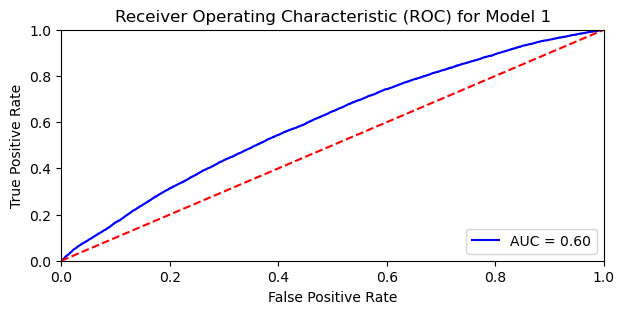

In [164]:
# Let's calculate the false positive and true positive rates to plot the Receiver Operating Characteristic (ROC) curve
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Model 1')
plt.show();

The plot above demonstrates the classification performance of our model. The red dotted line indicates what the performance of a random classification. 

In [165]:
y_test.value_counts()

0    54524
1    15120
Name: loan_default, dtype: int64

In [166]:
y_train.value_counts()

0    127270
1     35232
Name: loan_default, dtype: int64

In [167]:
# We know reduce the probability threshold from 50% to 40%.

# Selecting the probabilities that a customer will default
prob_default = lr.predict_proba(X_test)[:,1]
y_pred=np.where(prob_default>=0.4, 1, 0)
print('train accuracy :',lr.score(X_train,y_train))
print('test accuracy :',lr.score(X_test,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))
print("                      TP   FN     FP   TN") 
print("Confusion matrix:",confusion_matrix(y_test,y_pred, labels=[1,0]).ravel(),"\n")

train accuracy : 0.7829934400807375
test accuracy : 0.7823358796163346
precision : 0.37828371278458844 

recall : 0.014285714285714285 

f1 score: 0.027531706073545343 

              precision    recall  f1-score   support

           0       0.78      0.99      0.88     54524
           1       0.38      0.01      0.03     15120

    accuracy                           0.78     69644
   macro avg       0.58      0.50      0.45     69644
weighted avg       0.70      0.78      0.69     69644

                      TP   FN     FP   TN
Confusion matrix: [  216 14904   355 54169] 



By setting the cut-off to 40%, the number of TP increases to 216 (worth noting that FP also increases). However, this shows that our model assigns a small PD. 

## 4.3.2. Stepwise approach

In [168]:
# An automated algorithm which prioritises variables that maximise explanatory power

# Execute stepwise algorith to identify the most predictive risk drivers according to pvalue
result = stepwise_selection(X_train, y_train, initial_list=['ltv', 'perform_cns_score'])

print('resulting features:')
print(result)

Optimization terminated successfully.
         Current function value: 0.515232
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514662
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515509
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515501
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515531
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515508
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.514297
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515373
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.515489
  

Optimization terminated successfully.
         Current function value: 0.512108
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.512904
         Iterations 6
Add  pri_active_accts               with p-value 5.54569e-79
Optimization terminated successfully.
         Current function value: 0.511834
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511546
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511733
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511754
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.511806
         Iterations 6
Optimization terminat

Optimization terminated successfully.
         Current function value: 0.509172
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509182
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.509045
         Iterations 6
Add  avg_account_age                with p-value 4.10068e-41
Optimization terminated successfully.
         Current function value: 0.508640
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508414
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508634
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508610
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508634
         Iterations 6
Optimization terminat

## 4.3.3. Candidate model 2

In [169]:
X_train_step = X_train[result]
X_test_step = X_test[result]

LogReg = sm.Logit(y_train, X_train_step).fit()
LogReg.summary()

Optimization terminated successfully.
         Current function value: 0.508227
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           loan_default   No. Observations:               162502
Model:                          Logit   Df Residuals:                   162488
Method:                           MLE   Df Model:                           13
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.02795
Time:                        13:33:40   Log-Likelihood:                -82588.
converged:                       True   LL-Null:                       -84963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
ltv                                     0.0510      0.003     15.300      0.000       0.044       0.058
perform_cns_score                      -0.0004    2.9e-05    -15.465      0.000      -0.001      -0.000
const                                 -12.5560      0.531    -23.658      0.000     -13.596     -11.516
pri_overdue_accts                       0.3479      0.017     21.039      0.000       0.315       0.380
log_asset_cost                          2.1816      0.223      9.783      0.000       1.745       2.619
pri_active_accts                       -0.0715      0.007    -10.872      0.000      -0.084      -0.059
no_of_inquiries                         0.1560      0.008     18.528      0.000       0.139       0.172
obligor_age                            -0.0081      0.001    -12.186      0.000      -0.009      -0.007
delinquent_accts_in_last_six_months     0.2209      0.018     12.358      0.000       0.186       0.256
credit_history_length                  -0.0141      0.001    -14.060      0.000      -0.016      -0.012
avg_account_age                         0.0203      0.002     12.145      0.000       0.017       0.024
log_primary_instal_amt                  0.0195      0.002      8.973      0.000       0.015       0.024
log_disbursed_amount                   -1.5333      0.216     -7.113      0.000      -1.956      -1.111
pri_no_of_accts                        -0.0099      0.003     -3.503      0.000      -0.015      -0.004
=======================================================================================================
"""

In [170]:
# Train a logistic regression using the sklearn package to predict on test set
lr = LogisticRegression()
lr.fit(X_train_step,y_train)
y_pred=lr.predict(X_test_step)
print('train accuracy :',lr.score(X_train_step,y_train))
print('test accuracy :',lr.score(X_test_step,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))
print("                      TP   FN     FP   TN") 
print("Confusion matrix:",confusion_matrix(y_test,y_pred, labels=[1,0]).ravel(),"\n")

# Candidate model 2 has only 14 risk drivers which makes it more parsimonious than candidate model 1 but achieves the same accuracy rate.

LogisticRegression()

train accuracy : 0.7830672853257191
test accuracy : 0.7825225432198035
precision : 0.39344262295081966 

recall : 0.0031746031746031746 

f1 score: 0.006298386038577615 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54524
           1       0.39      0.00      0.01     15120

    accuracy                           0.78     69644
   macro avg       0.59      0.50      0.44     69644
weighted avg       0.70      0.78      0.69     69644

                      TP   FN     FP   TN
Confusion matrix: [   48 15072    74 54450] 



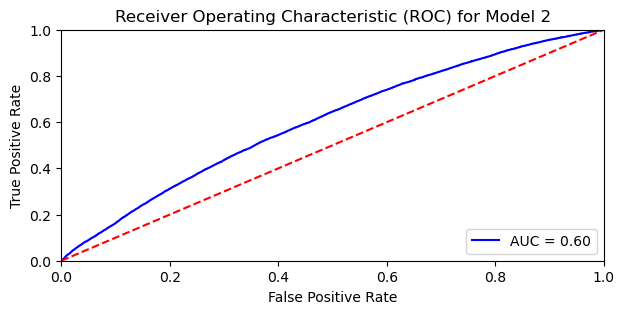

In [172]:
# Creating the ROC curve for model 2
probs = lr.predict_proba(X_test_step)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Model 2')
plt.show();

## 4.3.4. Variable selection using WoE and IV

In [173]:
# We are going to select 15 variables with the highest IV this time to include in our model
IV_table = pd.concat([discrete_WoE, continuous_WoE], axis=0).sort_values(by = 'Information Value', ascending= False)
IV_risk_drivers = IV_table[:15]
display(IV_risk_drivers)

,Risk driver,Information Value
0,ltv,0.066129
1,disbursed_amount,0.058762
2,perform_cns_score,0.045014
3,state_id,0.038779
7,pri_sanctioned_amount,0.020197
8,pri_disbursed_amount,0.019408
6,pri_current_balance,0.017009
19,credit_history_length,0.013276
3,pri_no_of_accts,0.012535
1,no_of_inquiries,0.011789


## 4.3.5. Candidate model 3

In [174]:
IV_drivers = list(IV_risk_drivers['Risk driver'].values)
IV_drivers.remove('employment_type')
IV_drivers = IV_drivers + ['self_employed', 'salaried', 'no_employment_info']

X_train_IV = train_df[IV_drivers]
X_train_IV = sm.add_constant(X_train_IV)
X_test_IV = test_df[IV_drivers]
X_test_IV = sm.add_constant(X_test_IV)

LogReg = sm.Logit(y_train, X_train_IV).fit()
LogReg.summary()

Optimization terminated successfully.
         Current function value: 0.506882
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           loan_default   No. Observations:               162502
Model:                          Logit   Df Residuals:                   162485
Method:                           MLE   Df Model:                           16
Date:                Mon, 12 Dec 2022   Pseudo R-squ.:                 0.03052
Time:                        13:35:16   Log-Likelihood:                -82369.
converged:                       True   LL-Null:                       -84963.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -2.5207        nan        nan        nan         nan         nan
ltv                              0.0212      0.001     33.291      0.000       0.020       0.022
disbursed_amount              1.106e-05   5.45e-07     20.294      0.000    9.99e-06    1.21e-05
perform_cns_score               -0.0002   2.48e-05     -8.072      0.000      -0.000      -0.000
state_id                         0.0278      0.001     20.734      0.000       0.025       0.030
pri_sanctioned_amount        -2.473e-07   1.31e-07     -1.895      0.058   -5.03e-07    8.49e-09
pri_disbursed_amount          1.123e-08    1.3e-07      0.086      0.931   -2.45e-07    2.67e-07
pri_current_balance           3.744e-08    9.9e-09      3.782      0.000     1.8e-08    5.68e-08
credit_history_length           -0.0031      0.000     -6.365      0.000      -0.004      -0.002
pri_no_of_accts                 -0.0188      0.003     -7.108      0.000      -0.024      -0.014
no_of_inquiries                  0.1597      0.008     18.808      0.000       0.143       0.176
pri_active_accts                -0.0170      0.008     -2.112      0.035      -0.033      -0.001
obligor_age                     -0.0096      0.001    -13.983      0.000      -0.011      -0.008
pri_overdue_accts                0.4658      0.015     30.083      0.000       0.435       0.496
new_accts_in_last_six_months    -0.0336      0.011     -3.056      0.002      -0.055      -0.012
self_employed                   -0.6739        nan        nan        nan         nan         nan
salaried                        -0.8863        nan        nan        nan         nan         nan
no_employment_info              -0.9605        nan        nan        nan         nan         nan
================================================================================================
"""

In [175]:
# Train a logistic regression using the sklearn package to predict on test set
lr = LogisticRegression()
lr.fit(X_train_IV,y_train)
y_pred=lr.predict(X_test_IV)
print('train accuracy :',lr.score(X_train_IV,y_train))
print('test accuracy :',lr.score(X_test_IV,y_test))
print("precision :",precision_score(y_test,y_pred),"\n")
print("recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print(classification_report(y_test,y_pred))
print("                      TP   FN     FP   TN") 
print("Confusion matrix:",confusion_matrix(y_test,y_pred, labels=[1,0]).ravel(),"\n")

LogisticRegression()

train accuracy : 0.7831534381115309
test accuracy : 0.7828671529492849
precision : 0.0 

recall : 0.0 

f1 score: 0.0 

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     54524
           1       0.00      0.00      0.00     15120

    accuracy                           0.78     69644
   macro avg       0.39      0.50      0.44     69644
weighted avg       0.61      0.78      0.69     69644

                      TP   FN     FP   TN
Confusion matrix: [    0 15120     2 54522] 



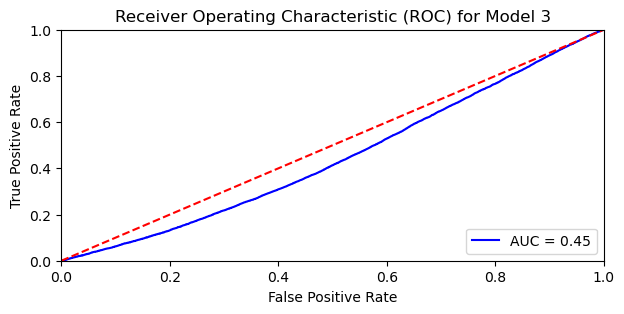

In [86]:
probs = lr.predict_proba(X_test_IV)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Model 3')
plt.show();

# Model 3 performs poorly. It predicts no defaults and also incorrectly predicts two performing customers to have defaulted. 
# This is the least accurate model thus far.

# 4.4. XGBoost
Since we fail to achieve sufficient accuracy in predicting defaults, we experiment with an **XGBoost Classifier** .

<span style="color:red"> WARNING: The tuning of the parameters and fitting of the XGBoost Classifier takes 20' to run. </span>

In [96]:
# We perform grid search to identify the optimum parameters for the XGBoost Classifier
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=-1, cv=3)

gsearch1.fit(X_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0, gpu_id=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=1,
           

({'mean_fit_time': array([26.94911234, 29.49261093, 27.01889801, 50.4755737 , 48.63345003,
         43.75601133, 67.1593736 , 67.26390394, 71.09451628, 90.54402685,
         98.71392465, 67.31598337]),
  'std_fit_time': array([ 1.05479428,  3.60611194,  2.43266068,  2.26191326,  2.81344988,
          6.79616325,  4.61983889,  1.72542207,  2.23717903,  1.68205373,
          2.03795437, 20.34842258]),
  'mean_score_time': array([0.17170493, 0.18316825, 0.15672716, 0.28209805, 0.27994235,
         0.22117201, 0.45594501, 0.46759295, 0.40019679, 0.70497584,
         0.69317317, 0.25175516]),
  'std_score_time': array([0.03050738, 0.01772743, 0.04987412, 0.06384121, 0.04839849,
         0.01319589, 0.03679142, 0.1468941 , 0.02035328, 0.08307534,
         0.07831229, 0.15617187]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         f

## 4.4.1. Candidate model 4

In [176]:
# We initiate the parameters identified from the Grid Search 
xgb = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=9,
 min_child_weight=1,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

In [177]:
# We train the XGBoost Classifier and predict on the test set
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
print("accuracy train:",xgb.score(X_train,y_train),"\n")
print("accuracy test:",xgb.score(X_test,y_test),"\n")
print("precision :",precision_score(y_test,y_pred),"\n")
print("Recall :",recall_score(y_test,y_pred),"\n")
print("f1 score:",f1_score(y_test,y_pred),"\n")
print("Confusion Matrix \n",confusion_matrix(y_test,y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=5000, n_jobs=4, nthread=4,
              num_parallel_tree=1, predictor='auto', ...)

accuracy train: 0.8300574762156774 

accuracy test: 0.7820056286255815 

precision : 0.45545977011494254 

Recall : 0.020965608465608465 

f1 score: 0.04008598887202833 

Confusion Matrix 
 [[54145   379]
 [14803   317]]


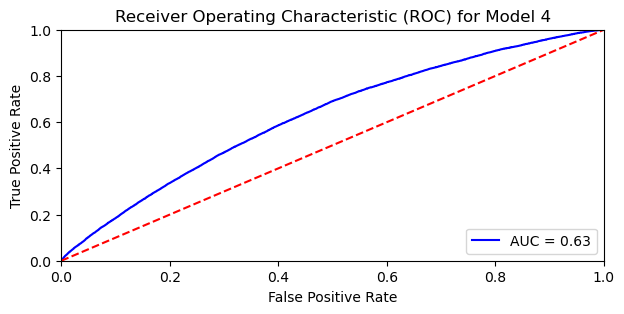

In [178]:
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Model 4')
plt.show();

The XGBoost model performs similarly to the Logistic regressions at **78%**. However, model 4 is able to predict **317** out of 13,885 actual defaults. This is still disappointing but it is much better than models 1-3.

We select **model 4** as the final model based on predictive performance.

# 5. Conclusions and Limitations

We expected to unveil strong relationships between customer characteristics and their PD. For example, LTV is actively considered by banks when determining whether to approve a loan or not.


#### Limitations
1. Lack of strong correlation between target variable and predictors
2. Problematic values: underage loan applicants and negative amounts for current balance
3. Uninformative variables: e.g. branch ID

These limitations meant that even state-of-the-art machine learning algorithms such as XGBoost cannot make a significant improvement over the Logistic regression.

# 6. Next Steps

We would have sought explanations from data teams and credit officers had this been a project with a bank. Given the time constraints, we were not able to contact the Kaggle contributor to clarify these points.

If this project were to be revisited, we would either seek an alternative dataset or contact the data provider to resolve all data quality queries.

 # 7. References

<a name="cite_note-1"></a>1. [^](#cite_ref-1)https://www.kaggle.com/datasets/mamtadhaker/lt-vehicle-loan-default-prediction?resource=download

<a name="cite_note-2"></a>2. [^](#cite_ref-2) https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html#:~:text=SAS%20and%20R-,What%20is%20Weight%20of%20Evidence%20(WOE)%3F,of%20good%20and%20bad%20customers.